In [1]:
# 1: Imports

import numpy as np
import cv2
import json
import os
import random
import zipfile
from PIL import Image
from typing import Dict, List, Tuple
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms
import torch.nn.functional as F

In [2]:
# Seeds for reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths
IMAGES_DIR = "/kaggle/input/delineate/dataset/images"
LABELS_DIR = "/kaggle/input/delineate/dataset/labels"

print(f"Device: {device}")
print(f"Images: {len(os.listdir(IMAGES_DIR))}")
print(f"Labels: {len(os.listdir(LABELS_DIR))}")

Device: cuda
Images: 3000
Labels: 3000


In [3]:
# 2: ConvNeXt-Tiny Regressor Model

class ErrorBarConvNeXt(nn.Module):
    def __init__(self, patch_size=225, dropout_rate=0.3):
        super(ErrorBarConvNeXt, self).__init__()
        
        # Load pretrained ConvNeXt-Tiny
        convnext = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        
        # Extract feature extractor
        self.features = convnext.features
        self.avgpool = convnext.avgpool
        
        # ConvNeXt-Tiny outputs 768 features
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.7),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            
            nn.Linear(128, 2)
        )
        
        # Initialize weights for new layers
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.regressor.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.regressor(x)
        # Used softplus to ensure non-negative outputs for distances
        x = F.softplus(x)
        return x

print("ConvNeXt-Tiny Model defined")
print(f"Parameters: {sum(p.numel() for p in ErrorBarConvNeXt().parameters()):,}")

ConvNeXt-Tiny Model defined
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 183MB/s]


Parameters: 28,378,594


In [4]:
# 3: Dataset Class with Augmentation

class ErrorBarDataset(Dataset):
    def __init__(self, images_dir, labels_dir, file_ids=None, patch_size=225, augment=False):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.patch_size = patch_size
        self.augment = augment
        self.samples = []
        
        # Enhanced transforms with augmentation
        if augment:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
                transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
                transforms.RandomHorizontalFlip(p=0.3),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        
        # Get file IDs
        if file_ids is None:
            file_ids = [f.replace('.json', '') for f in os.listdir(labels_dir) if f.endswith('.json')]
        
        # Load samples
        for file_id in file_ids:
            image_path = os.path.join(images_dir, f"{file_id}.png")
            label_path = os.path.join(labels_dir, f"{file_id}.json")
            
            if not os.path.exists(image_path):
                continue
            
            with open(label_path, 'r') as f:
                labels = json.load(f)
            
            for line in labels:
                line_name = line["label"]["lineName"]
                for point in line["points"]:
                    if point["label"] != "":
                        continue
                    
                    # Only include points with error bars
                    if point["topBarPixelDistance"] > 0 or point["bottomBarPixelDistance"] > 0:
                        self.samples.append({
                            "file_id": file_id,
                            "image_path": image_path,
                            "line_name": line_name,
                            "x": point["x"],
                            "y": point["y"],
                            "top_dist": point["topBarPixelDistance"],
                            "bottom_dist": point["bottomBarPixelDistance"]
                        })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        image = cv2.imread(sample["image_path"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        x, y = int(round(sample["x"])), int(round(sample["y"]))
        half = self.patch_size // 2
        
        # Extract patch with padding
        y_start = max(0, y - half)
        y_end = min(h, y + half)
        x_start = max(0, x - half)
        x_end = min(w, x + half)
        
        patch = image[y_start:y_end, x_start:x_end]
        
        # Pad if needed
        pad_top = max(0, half - y)
        pad_bottom = max(0, (y + half) - h)
        pad_left = max(0, half - x)
        pad_right = max(0, (x + half) - w)
        
        if pad_top > 0 or pad_bottom > 0 or pad_left > 0 or pad_right > 0:
            patch = cv2.copyMakeBorder(patch, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_REFLECT)
        
        patch = cv2.resize(patch, (self.patch_size, self.patch_size))
        # Apply transforms
        patch = self.transform(patch)
        
        targets = torch.tensor([sample["top_dist"], sample["bottom_dist"]], dtype=torch.float32)
        
        return patch, targets

print("Dataset class defined")                   

Dataset class defined


In [5]:
# 4: Train/Val/Test Split

# Get all file IDs
all_files = [f.replace('.json', '') for f in os.listdir(LABELS_DIR) if f.endswith('.json')]
random.shuffle(all_files)

# 70% train, 15% val, 15% test
train_idx = int(len(all_files) * 0.7)
val_idx = int(len(all_files) * 0.85)

train_files = all_files[:train_idx]
val_files = all_files[train_idx:val_idx]
test_files = all_files[val_idx:]

print(f"Total files: {len(all_files)}")
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

# Create datasets with augmentation for training
train_dataset = ErrorBarDataset(IMAGES_DIR, LABELS_DIR, train_files, augment=True)
val_dataset = ErrorBarDataset(IMAGES_DIR, LABELS_DIR, val_files, augment=False)
test_dataset = ErrorBarDataset(IMAGES_DIR, LABELS_DIR, test_files, augment=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders with optimized settings
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

Total files: 3000
Train files: 2100
Validation files: 450
Test files: 450
Train samples: 37258
Val samples: 8135
Test samples: 7758


In [6]:
# Error Bar Analysis for Patch Size Selection

top_distances = []
bottom_distances = []

# Analyze all training files
for file_id in tqdm(train_files, desc="Analyzing"):
    label_path = os.path.join(LABELS_DIR, f"{file_id}.json")
    
    if not os.path.exists(label_path):
        continue
    
    with open(label_path, 'r') as f:
        labels = json.load(f)
    
    for line in labels:
        for point in line["points"]:
            if point["label"] == "" and (point["topBarPixelDistance"] > 0 or point["bottomBarPixelDistance"] > 0):
                top_distances.append(point["topBarPixelDistance"])
                bottom_distances.append(point["bottomBarPixelDistance"])

top_distances = np.array(top_distances)
bottom_distances = np.array(bottom_distances)
max_distances = np.maximum(top_distances, bottom_distances)
total_distances = top_distances + bottom_distances

print("\n" + "=" * 60)
print("ERROR BAR STATISTICS")
print("=" * 60)
print(f"Total samples: {len(top_distances):,}")
print()
print(f"Top bar - Mean: {np.mean(top_distances):6.2f}px  |  Median: {np.median(top_distances):6.2f}px  |  95th: {np.percentile(top_distances, 95):6.2f}px  |  Max: {np.max(top_distances):6.2f}px")
print(f"Bottom bar - Mean: {np.mean(bottom_distances):6.2f}px  |  Median: {np.median(bottom_distances):6.2f}px  |  95th: {np.percentile(bottom_distances, 95):6.2f}px  |  Max: {np.max(bottom_distances):6.2f}px")
print(f"Max of both - Mean: {np.mean(max_distances):6.2f}px  |  Median: {np.median(max_distances):6.2f}px  |  95th: {np.percentile(max_distances, 95):6.2f}px  |  Max: {np.max(max_distances):6.2f}px")
print()

p95_max = np.percentile(max_distances, 95)
p99_max = np.percentile(max_distances, 99)

print(f"95th percentile max distance: {p95_max:.1f}px")
print(f"99th percentile max distance: {p99_max:.1f}px")

print("=" * 60)

Analyzing:   0%|          | 0/2100 [00:00<?, ?it/s]


ERROR BAR STATISTICS
Total samples: 37,258

Top bar - Mean:  43.98px  |  Median:  39.23px  |  95th:  91.79px  |  Max: 306.32px
Bottom bar - Mean:  43.91px  |  Median:  39.14px  |  95th:  91.96px  |  Max: 312.52px
Max of both - Mean:  45.67px  |  Median:  40.89px  |  95th:  95.10px  |  Max: 312.52px

95th percentile max distance: 95.1px
99th percentile max distance: 128.0px


Training started...


Epoch 1/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

✓ Epoch 1/30 - Train: 14.9200, Val: 4.5620 [BEST]


Epoch 2/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

✓ Epoch 2/30 - Train: 6.0599, Val: 3.4698 [BEST]


Epoch 3/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 3/30 - Train: 4.9476, Val: 3.5329


Epoch 4/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

✓ Epoch 4/30 - Train: 4.4645, Val: 2.9274 [BEST]


Epoch 5/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

✓ Epoch 5/30 - Train: 4.1825, Val: 2.3474 [BEST]


Epoch 6/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 6/30 - Train: 4.5034, Val: 2.6307


Epoch 7/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 7/30 - Train: 4.1853, Val: 2.6660


Epoch 8/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 8/30 - Train: 3.9831, Val: 2.4114


Epoch 9/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 9/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 9/30 - Train: 3.7211, Val: 2.4798


Epoch 10/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 10/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

✓ Epoch 10/30 - Train: 3.5561, Val: 2.3295 [BEST]


Epoch 11/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 11/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

✓ Epoch 11/30 - Train: 3.4241, Val: 2.2212 [BEST]


Epoch 12/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 12/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 12/30 - Train: 3.2886, Val: 2.3374


Epoch 13/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 13/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 13/30 - Train: 3.1883, Val: 2.8563


Epoch 14/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 14/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 14/30 - Train: 3.1198, Val: 2.6722


Epoch 15/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 15/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 15/30 - Train: 3.0789, Val: 3.0799


Epoch 16/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 16/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 16/30 - Train: 3.4379, Val: 3.1588


Epoch 17/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 17/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 17/30 - Train: 3.4112, Val: 2.8624


Epoch 18/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 18/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

✓ Epoch 18/30 - Train: 3.3034, Val: 1.5734 [BEST]


Epoch 19/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 19/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 19/30 - Train: 3.2675, Val: 1.9703


Epoch 20/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 20/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 20/30 - Train: 3.1638, Val: 2.3825


Epoch 21/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 21/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 21/30 - Train: 3.0521, Val: 2.7024


Epoch 22/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 22/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 22/30 - Train: 3.0507, Val: 2.3399


Epoch 23/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 23/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 23/30 - Train: 2.9716, Val: 2.7382


Epoch 24/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 24/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 24/30 - Train: 2.9048, Val: 1.7460


Epoch 25/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 25/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

✓ Epoch 25/30 - Train: 2.8559, Val: 1.3947 [BEST]


Epoch 26/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 26/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 26/30 - Train: 2.7744, Val: 2.0883


Epoch 27/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 27/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 27/30 - Train: 2.7641, Val: 2.2382


Epoch 28/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 28/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 28/30 - Train: 2.7608, Val: 1.4062


Epoch 29/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 29/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

✓ Epoch 29/30 - Train: 2.6898, Val: 1.3405 [BEST]


Epoch 30/30 [Train]:   0%|          | 0/583 [00:00<?, ?it/s]

Epoch 30/30 [Val]:   0%|          | 0/128 [00:00<?, ?it/s]

  Epoch 30/30 - Train: 2.6529, Val: 1.9288
Training completed. Best validation loss: 1.3405


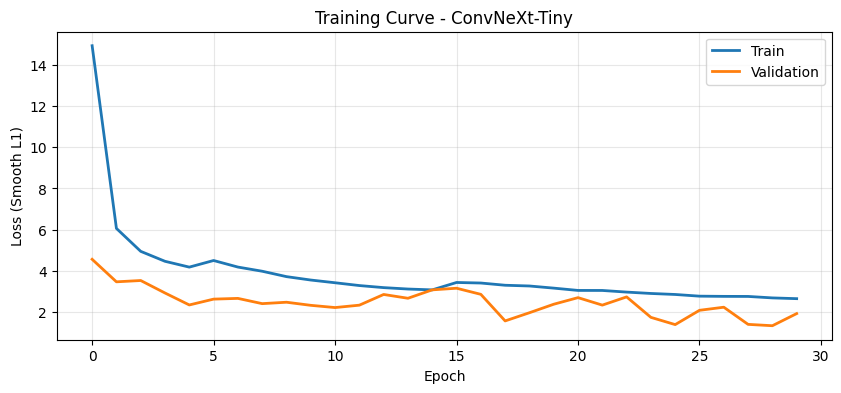

In [7]:
# 5: Train Model

model = ErrorBarConvNeXt().to(device)
criterion = nn.SmoothL1Loss()

optimizer = optim.AdamW([
    {'params': model.features.parameters(), 'lr': 5e-5, 'weight_decay': 0.01},
    {'params': model.regressor.parameters(), 'lr': 1e-3, 'weight_decay': 0.01}
])

# Cosine annealing with warm restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

# Early stopping
patience = 10
patience_counter = 0
num_epochs = 30
best_val_loss = float('inf')
train_losses = []
val_losses = []

print("Training started...")
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for patches, targets in train_pbar:
        patches, targets = patches.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(patches)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validate
    model.eval()
    val_loss = 0
    
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for patches, targets in val_pbar:
            patches, targets = patches.to(device), targets.to(device)
            outputs = model(patches)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Step scheduler
    scheduler.step()
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, "best_model.pth")
        patience_counter = 0
        print(f"✓ Epoch {epoch+1}/{num_epochs} - Train: {train_loss:.4f}, Val: {val_loss:.4f} [BEST]")
    else:
        patience_counter += 1
        print(f"  Epoch {epoch+1}/{num_epochs} - Train: {train_loss:.4f}, Val: {val_loss:.4f}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Load best model
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Training completed. Best validation loss: {best_val_loss:.4f}")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train', linewidth=2)
plt.plot(val_losses, label='Validation', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (Smooth L1)')
plt.legend()
plt.title('Training Curve - ConvNeXt-Tiny')
plt.grid(alpha=0.3)
plt.savefig("training_curve.png", dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# 6: Prediction Function

def predict_error_bars(model, image_path, x, y, patch_size=225):
    """Predict error bar distances for a single point."""
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    x_int, y_int = int(round(x)), int(round(y))
    half = patch_size // 2
    
    # Extract patch
    y_start = max(0, y_int - half)
    y_end = min(h, y_int + half)
    x_start = max(0, x_int - half)
    x_end = min(w, x_int + half)
    
    patch = image[y_start:y_end, x_start:x_end]
    
    # Pad if needed
    pad_top = max(0, half - y_int)
    pad_bottom = max(0, (y_int + half) - h)
    pad_left = max(0, half - x_int)
    pad_right = max(0, (x_int + half) - w)
    
    if pad_top > 0 or pad_bottom > 0 or pad_left > 0 or pad_right > 0:
        patch = cv2.copyMakeBorder(patch, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_REFLECT)
    
    patch = cv2.resize(patch, (patch_size, patch_size))
    patch = transform(patch)
    patch = patch.unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(patch)
        top_dist, bottom_dist = output[0].cpu().numpy()
    
    return float(top_dist), float(bottom_dist)

def process_input_json(model, image_path, input_data):
    """Process input JSON and return output JSON in assignment format."""
    
    output = {
        "image_file": input_data["image_file"],
        "error_bars": []
    }
    
    for line_data in input_data["data_points"]:
        line_result = {
            "lineName": line_data["lineName"],
            "points": []
        }
        
        for point in line_data["points"]:
            x, y = point["x"], point["y"]
            top_dist, bottom_dist = predict_error_bars(model, image_path, x, y)
            
            line_result["points"].append({
                "data_point": {"x": x, "y": y},
                "upper_error_bar": {"x": x, "y": y - top_dist},
                "lower_error_bar": {"x": x, "y": y + bottom_dist}
            })
        
        output["error_bars"].append(line_result)
    
    return output

print("Prediction functions defined")

Prediction functions defined


In [9]:
# 7: Evaluate on Test Set

def create_input_from_label(labels_dir, file_id):
    
    with open(os.path.join(labels_dir, f"{file_id}.json"), 'r') as f:
        labels = json.load(f)
    
    input_data = {
        "image_file": f"{file_id}.png",
        "data_points": []
    }
    
    for line in labels:
        points = []
        for p in line["points"]:
            if p["label"] == "" and (p["topBarPixelDistance"] > 0 or p["bottomBarPixelDistance"] > 0):
                points.append({"x": p["x"], "y": p["y"]})
        
        if points:
            input_data["data_points"].append({
                "lineName": line["label"]["lineName"],
                "points": points
            })
    
    return input_data

def get_ground_truth(labels_dir, file_id):
    """Get ground truth in assignment output format."""
    
    with open(os.path.join(labels_dir, f"{file_id}.json"), 'r') as f:
        labels = json.load(f)
    
    output = {
        "image_file": f"{file_id}.png",
        "error_bars": []
    }
    
    for line in labels:
        points = []
        for p in line["points"]:
            if p["label"] == "" and (p["topBarPixelDistance"] > 0 or p["bottomBarPixelDistance"] > 0):
                points.append({
                    "data_point": {"x": p["x"], "y": p["y"]},
                    "upper_error_bar": {"x": p["x"], "y": p["y"] - p["topBarPixelDistance"]},
                    "lower_error_bar": {"x": p["x"], "y": p["y"] + p["bottomBarPixelDistance"]}
                })
        
        if points:
            output["error_bars"].append({
                "lineName": line["label"]["lineName"],
                "points": points
            })
    
    return output

# Evaluate

print("Evaluating on test set...")
upper_errors = []
lower_errors = []

for file_id in tqdm(test_files, desc="Evaluating"):
    image_path = os.path.join(IMAGES_DIR, f"{file_id}.png")
    
    if not os.path.exists(image_path):
        continue
    
    # Get input and ground truth
    input_data = create_input_from_label(LABELS_DIR, file_id)
    ground_truth = get_ground_truth(LABELS_DIR, file_id)
    
    # Get prediction
    prediction = process_input_json(model, image_path, input_data)
    
    # Compare
    for gt_line, pred_line in zip(ground_truth["error_bars"], prediction["error_bars"]):
        for gt_p, pred_p in zip(gt_line["points"], pred_line["points"]):
            upper_errors.append(abs(pred_p["upper_error_bar"]["y"] - gt_p["upper_error_bar"]["y"]))
            lower_errors.append(abs(pred_p["lower_error_bar"]["y"] - gt_p["lower_error_bar"]["y"]))

upper_errors = np.array(upper_errors)
lower_errors = np.array(lower_errors)
total_errors = upper_errors + lower_errors

print("Evaluation completed")

Evaluating on test set...


Evaluating:   0%|          | 0/450 [00:00<?, ?it/s]

Evaluation completed


In [10]:
# 8: Print Evaluation Results

print()
print("=" * 60)
print("EVALUATION RESULTS")
print("=" * 60)
print(f"Total points evaluated: {len(upper_errors)}")
print()
print("Mean Absolute Error (MAE):")
print(f"   Upper error bar: {np.mean(upper_errors):.2f} pixels")
print(f"   Lower error bar: {np.mean(lower_errors):.2f} pixels")
print(f"   Total: {np.mean(total_errors):.2f} pixels")
print()
print("Median Absolute Error:")
print(f"   Upper error bar: {np.median(upper_errors):.2f} pixels")
print(f"   Lower error bar: {np.median(lower_errors):.2f} pixels")
print(f"   Total: {np.median(total_errors):.2f} pixels")
print()
print("Accuracy (% within threshold):")
print(f"   Within 2px (each): {np.mean(total_errors < 4) * 100:.1f}%")
print(f"   Within 5px (each): {np.mean(total_errors < 10) * 100:.1f}%")
print(f"   Within 10px (each): {np.mean(total_errors < 20) * 100:.1f}%")
print("=" * 60)


EVALUATION RESULTS
Total points evaluated: 7758

Mean Absolute Error (MAE):
   Upper error bar: 1.77 pixels
   Lower error bar: 1.75 pixels
   Total: 3.52 pixels

Median Absolute Error:
   Upper error bar: 0.76 pixels
   Lower error bar: 0.77 pixels
   Total: 1.62 pixels

Accuracy (% within threshold):
   Within 2px (each): 82.3%
   Within 5px (each): 93.2%
   Within 10px (each): 98.2%


In [11]:
# 9: Generate Complete Test Outputs with Images

import shutil

# Create output directory
os.makedirs("test_outputs", exist_ok=True)
print(f"Generating outputs for all {len(test_files)} test images...")

# Process ALL test files
for i, file_id in enumerate(tqdm(test_files, desc="Processing")):
    image_path = os.path.join(IMAGES_DIR, f"{file_id}.png")
    
    if not os.path.exists(image_path):
        continue
    
    # Create input from labels
    input_data = create_input_from_label(LABELS_DIR, file_id)
    
    # Get model prediction
    prediction = process_input_json(model, image_path, input_data)
    
    # Save input JSON
    with open(f"test_outputs/input_{i+1}.json", 'w') as f:
        json.dump(input_data, f, indent=2)
    
    # Save output JSON
    with open(f"test_outputs/output_{i+1}.json", 'w') as f:
        json.dump(prediction, f, indent=2)
    
    # Copy plot image
    shutil.copy(image_path, f"test_outputs/plot_{i+1}.png")

# Create final ZIP with everything
print("Creating comprehensive ZIP file...")
with zipfile.ZipFile("test_outputs_complete.zip", 'w', zipfile.ZIP_DEFLATED) as zipf:
    for filename in os.listdir("test_outputs"):
        zipf.write(os.path.join("test_outputs", filename), filename)

# Summary
num_files = len([f for f in os.listdir("test_outputs") if f.endswith('.json')]) // 2
zip_size = os.path.getsize("test_outputs_complete.zip") / (1024 * 1024)  # MB

print("\n" + "=" * 60)
print("COMPLETE TEST OUTPUTS GENERATED")
print("=" * 60)
print(f"Total test images processed: {num_files}")
print(f"Files in ZIP:")
print(f"  - {num_files} input JSONs")
print(f"  - {num_files} output JSONs")
print(f"  - {num_files} plot images")
print("=" * 60)

# Display download link
from IPython.display import FileLink, display
display(FileLink("test_outputs_complete.zip"))

# Show sample files
print("\nSample Input (first 1000 chars):")
with open("test_outputs/input_1.json", 'r') as f:
    print(json.dumps(json.load(f), indent=2)[:1000])

print("\nSample Output (first 1000 chars):")
with open("test_outputs/output_1.json", 'r') as f:
    print(json.dumps(json.load(f), indent=2)[:1000])

Generating outputs for all 450 test images...


Processing:   0%|          | 0/450 [00:00<?, ?it/s]

Creating comprehensive ZIP file...

COMPLETE TEST OUTPUTS GENERATED
Total test images processed: 450
Files in ZIP:
  - 450 input JSONs
  - 450 output JSONs
  - 450 plot images


/kaggle/working/test_outputs_complete.zip


Sample Input (first 1000 chars):
{
  "image_file": "9bd56f57-ae8d-40f9-ada4-d5c18818ce1e.png",
  "data_points": [
    {
      "lineName": "HbA1c_Insulin",
      "points": [
        {
          "x": 123.996603,
          "y": 144.313515
        }
      ]
    },
    {
      "lineName": "HbA1c_Combination",
      "points": [
        {
          "x": 399.102655,
          "y": 478.724572
        },
        {
          "x": 423.882614,
          "y": 430.83131
        },
        {
          "x": 822.701727,
          "y": 261.139257
        }
      ]
    },
    {
      "lineName": "HbA1c_Exenatide_ER",
      "points": [
        {
          "x": 143.092536,
          "y": 540.475942
        },
        {
          "x": 612.823217,
          "y": 230.239131
        }
      ]
    },
    {
      "lineName": "HbA1c_Placebo",
      "points": [
        {
          "x": 144.461716,
          "y": 374.536428
        },
        {
          "x": 330.774688,
          "y": 557.323972
        },
       

Sample Visualization (Green=Truth, Red=Prediction):


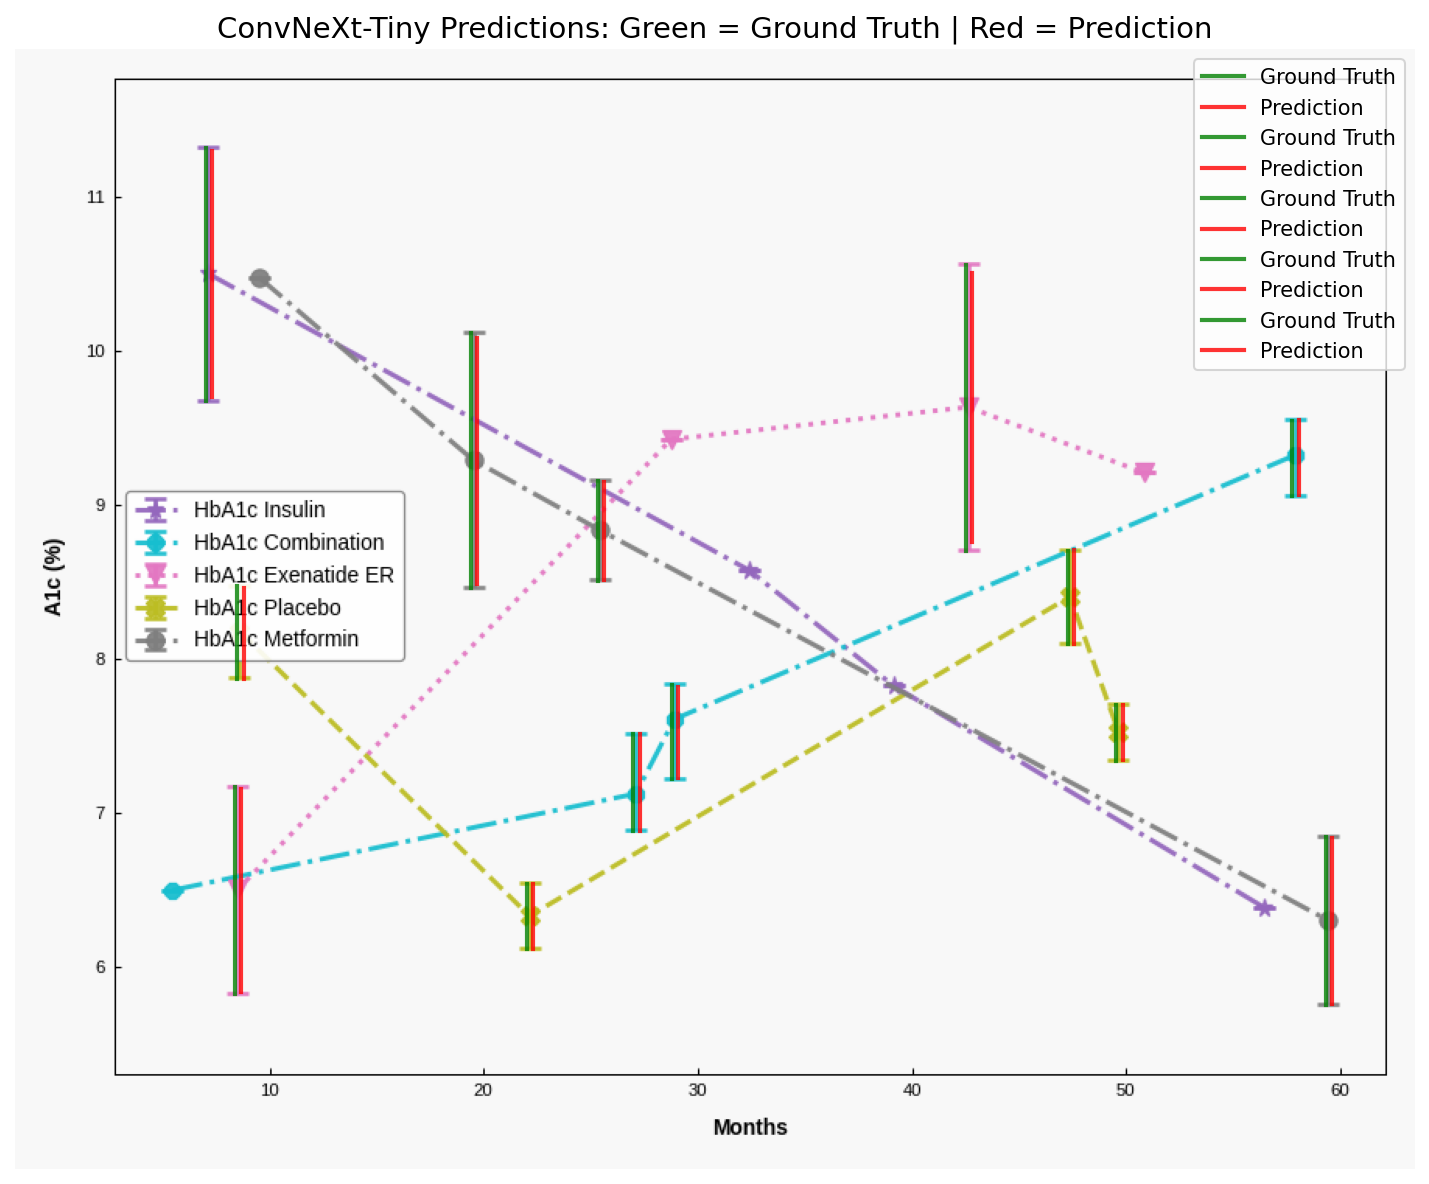

In [12]:
# 10: Visualize Sample Predictions

from IPython.display import Image as IPImage, display

def visualize_sample(file_id, images_dir, labels_dir, model):
    """Visualize prediction vs ground truth."""
    
    image_path = os.path.join(images_dir, f"{file_id}.png")
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    input_data = create_input_from_label(labels_dir, file_id)
    ground_truth = get_ground_truth(labels_dir, file_id)
    prediction = process_input_json(model, image_path, input_data)
    
    plt.figure(figsize=(14, 8))
    plt.imshow(image_rgb)
    
    # Draw ground truth (green) and prediction (red)
    for gt_line, pred_line in zip(ground_truth["error_bars"], prediction["error_bars"]):
        for gt_p, pred_p in zip(gt_line["points"], pred_line["points"]):
            x = gt_p["data_point"]["x"]
            
            # Ground truth - green
            gt_upper = gt_p["upper_error_bar"]["y"]
            gt_lower = gt_p["lower_error_bar"]["y"]
            plt.plot([x-2, x-2], [gt_upper, gt_lower], 'g-', linewidth=2, alpha=0.8, label='Ground Truth' if gt_p == gt_line["points"][0] else "")
            
            # Prediction - red
            pred_upper = pred_p["upper_error_bar"]["y"]
            pred_lower = pred_p["lower_error_bar"]["y"]
            plt.plot([x+2, x+2], [pred_upper, pred_lower], 'r-', linewidth=2, alpha=0.8, label='Prediction' if pred_p == pred_line["points"][0] else "")
    
    plt.title("ConvNeXt-Tiny Predictions: Green = Ground Truth | Red = Prediction", fontsize=14)
    plt.axis('off')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig("sample_visualization.png", dpi=150, bbox_inches='tight')
    plt.close()

# Visualize
visualize_sample(test_files[0], IMAGES_DIR, LABELS_DIR, model)
print("Sample Visualization (Green=Truth, Red=Prediction):")
display(IPImage(filename="sample_visualization.png"))

Sample 1: 9bd56f57-ae8d-40f9-ada4-d5c18818ce1e


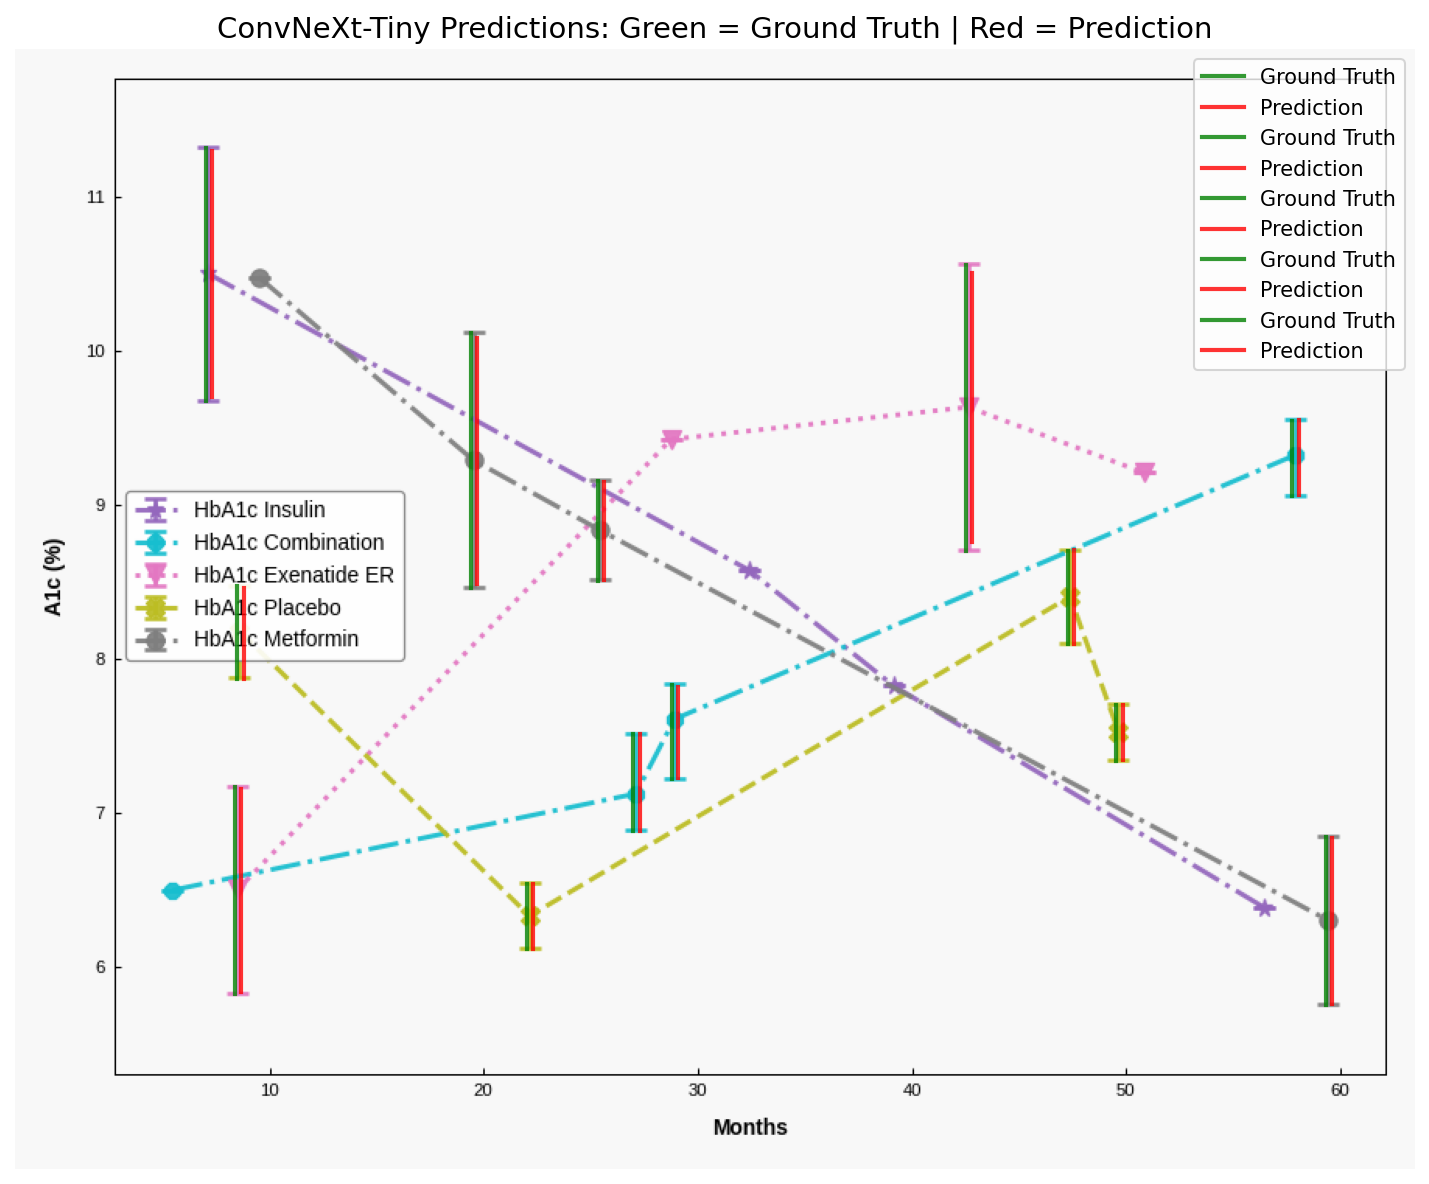

Sample 2: 66177b53-8ab5-4f02-bf3d-5b7afcab00c5


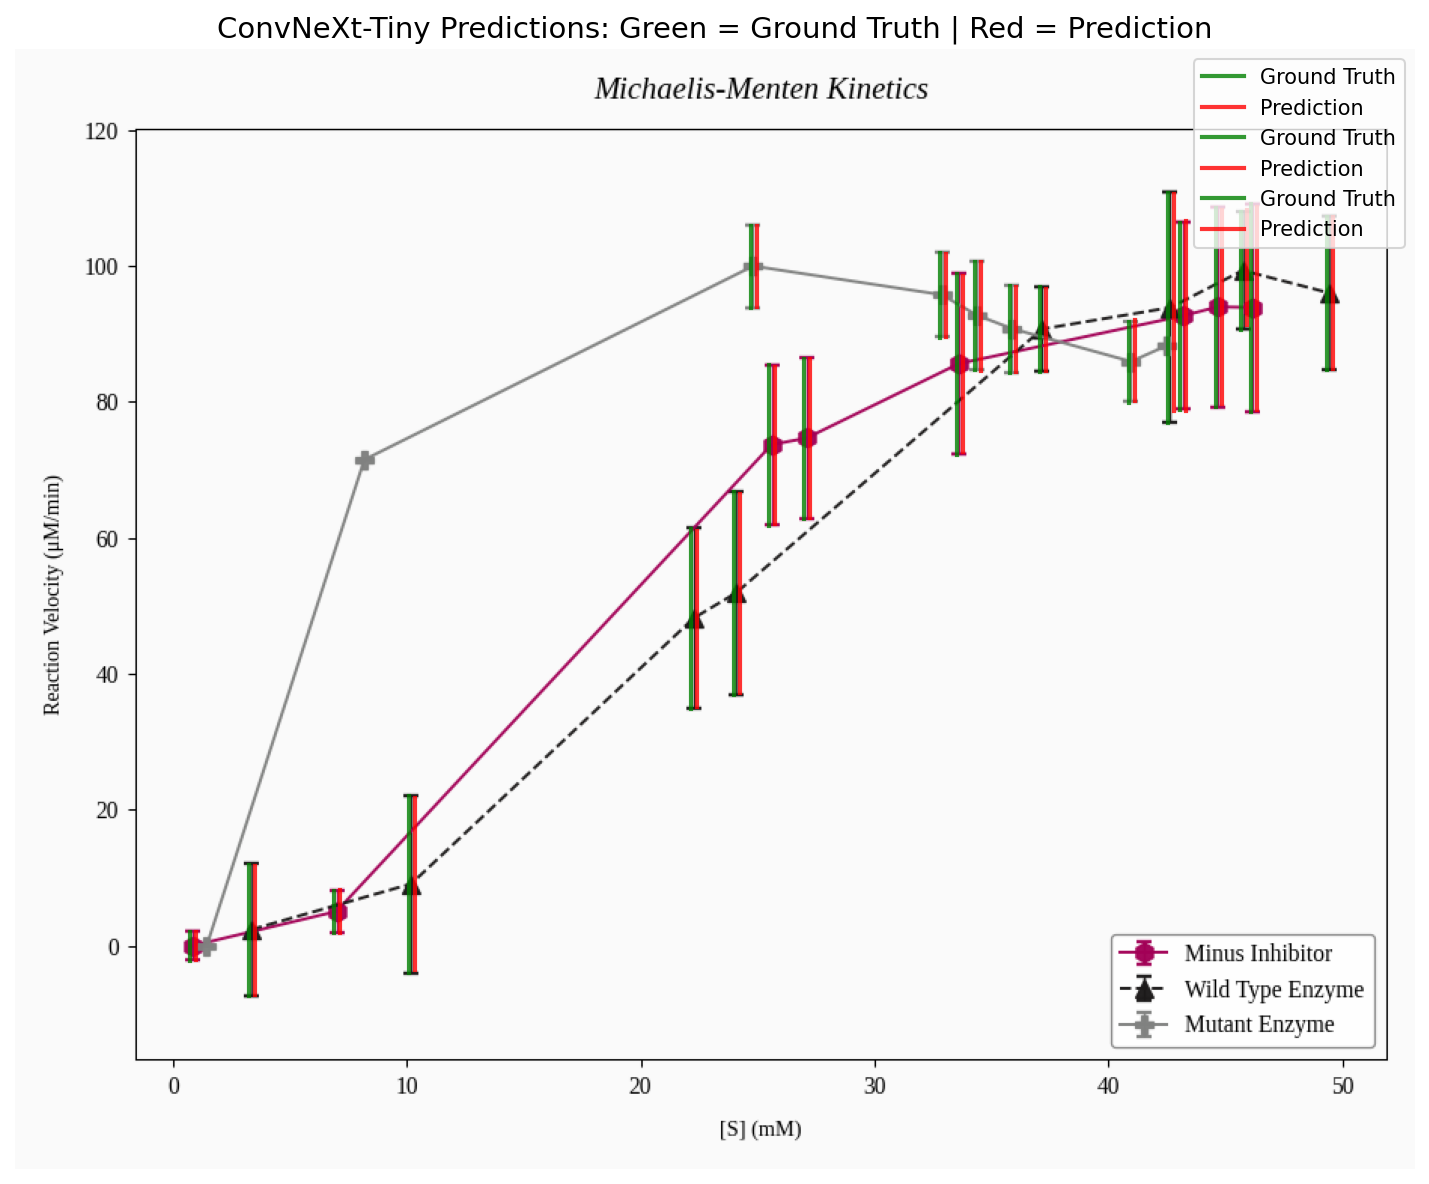

Sample 3: 7d15c15b-07b1-46bc-9f6a-3ac9f5f87ade


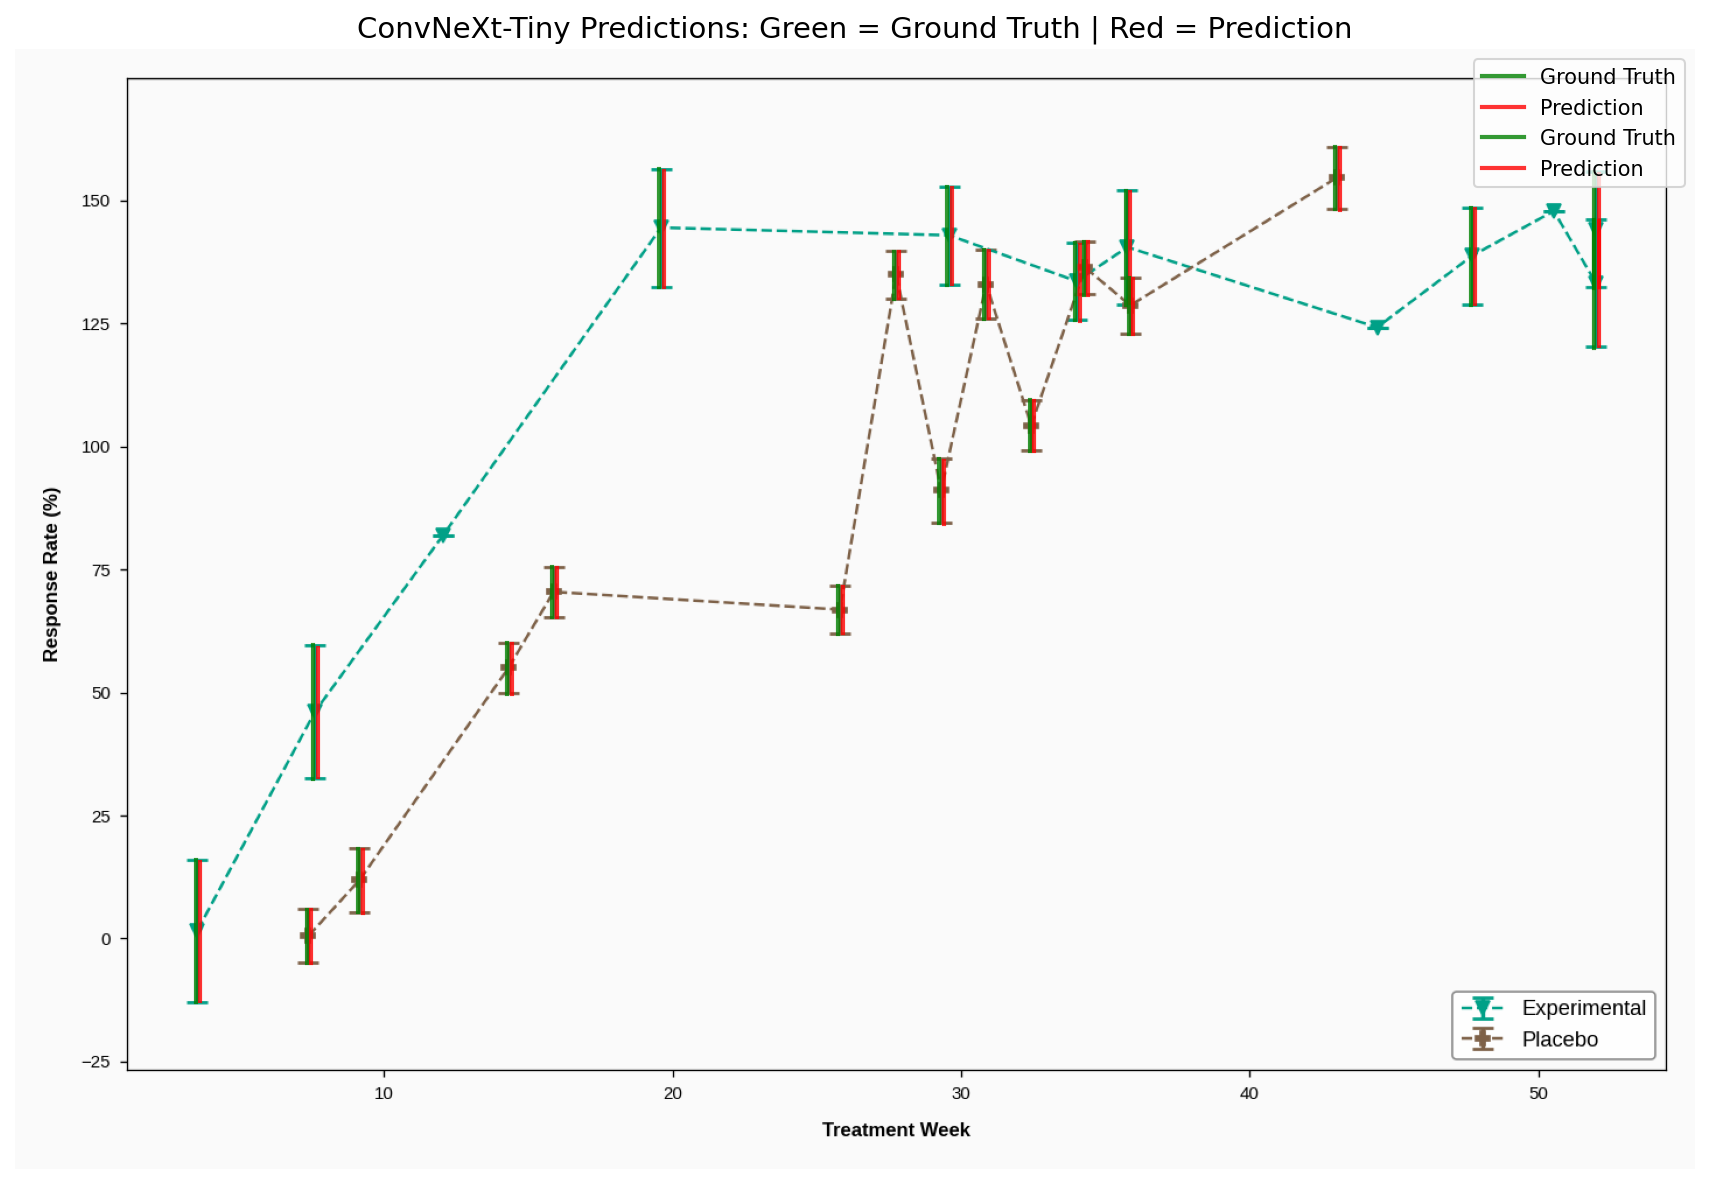

Sample 4: 96a68c4a-d9d8-4cdf-bc2b-c1389547c866


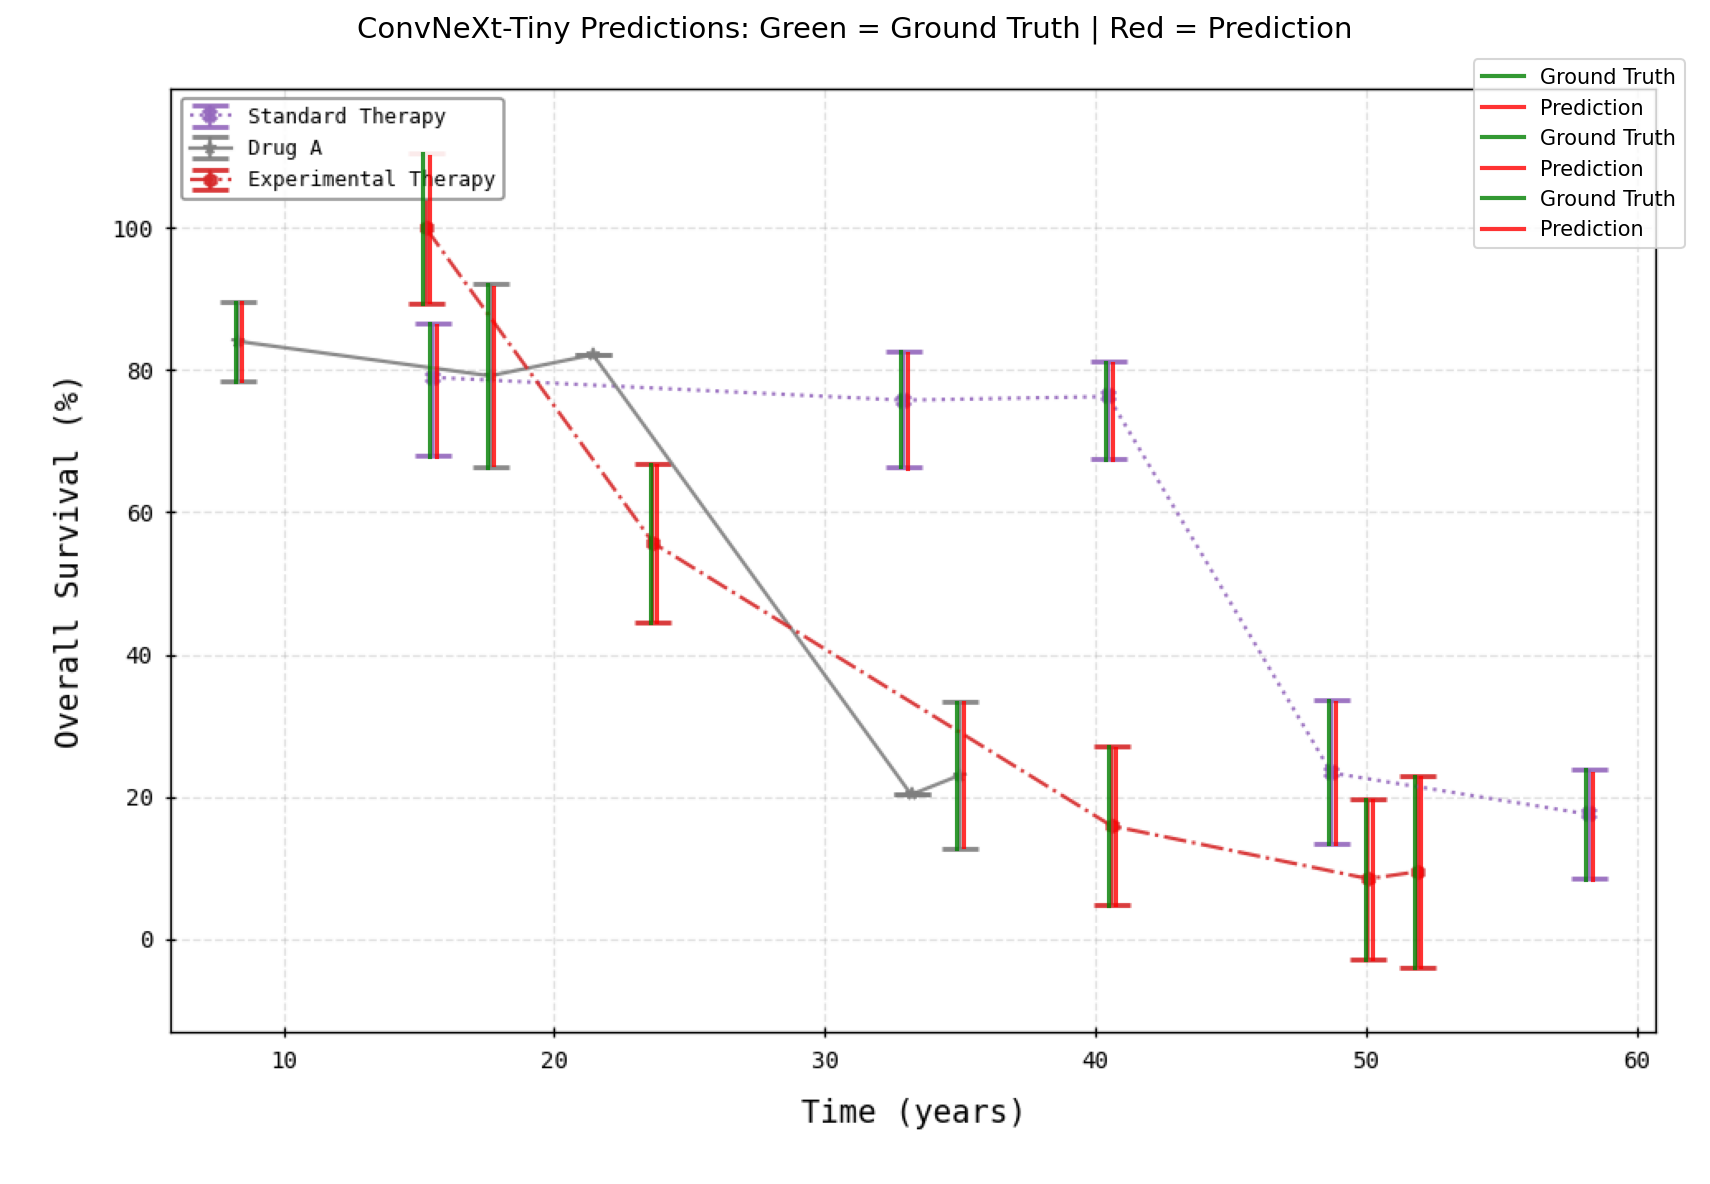

Sample 5: 350ca2f7-e1d4-4865-9f95-df21f85bb3c0


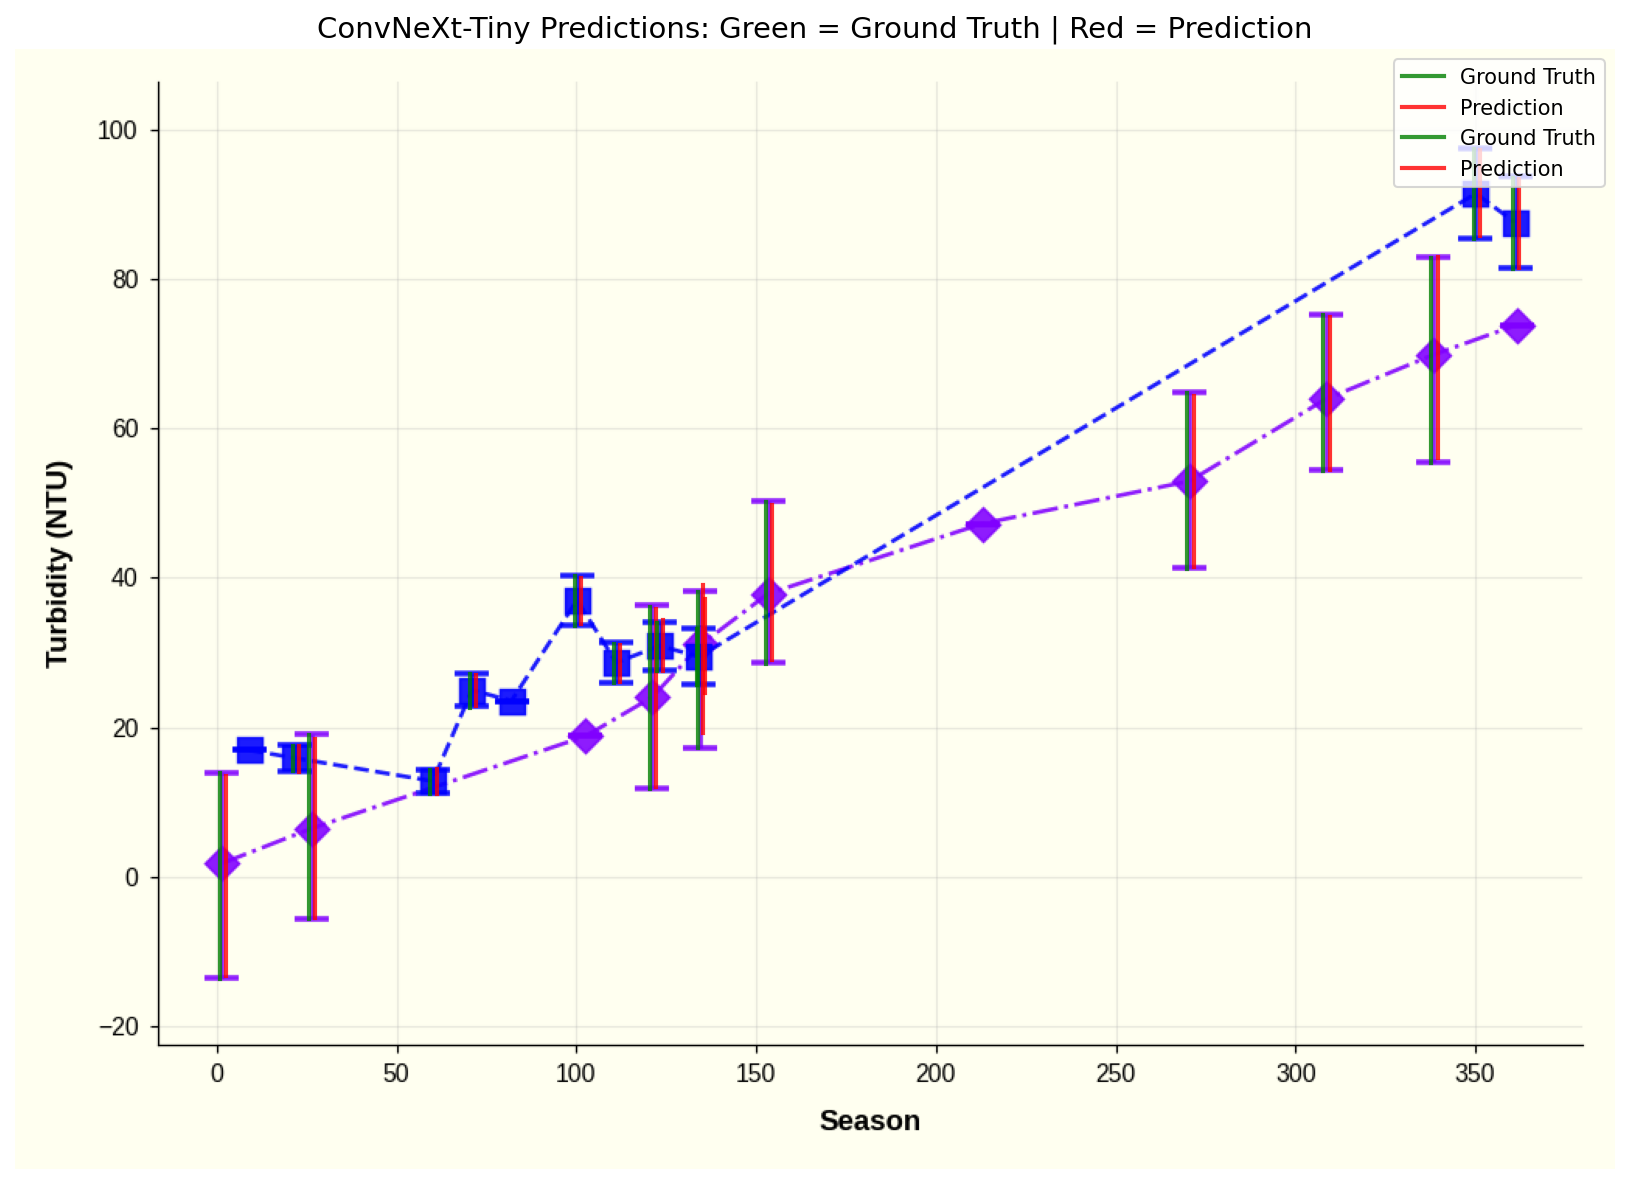

Sample 6: 51d8adff-cf72-42a7-a500-264ae5e5e6dd


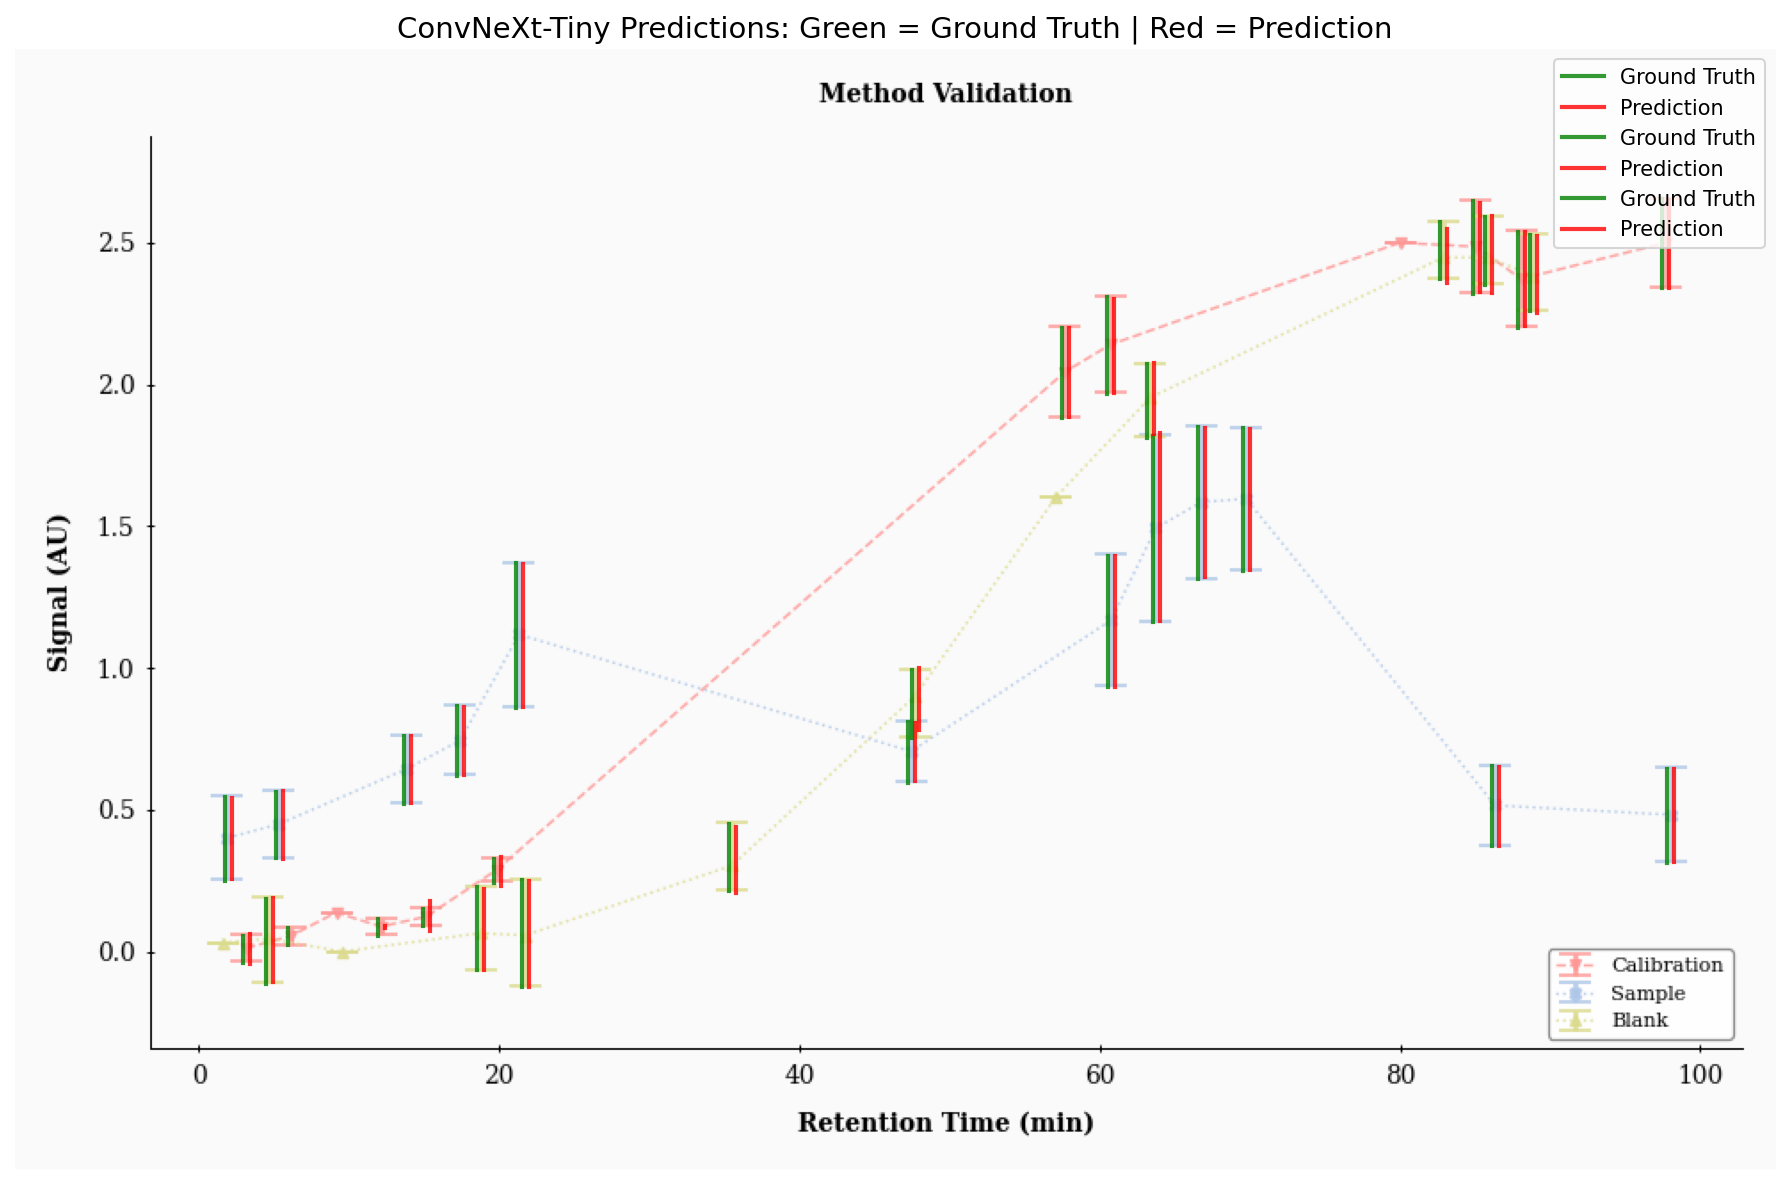

Sample 7: fc341784-1217-4361-9bed-4652e8354414


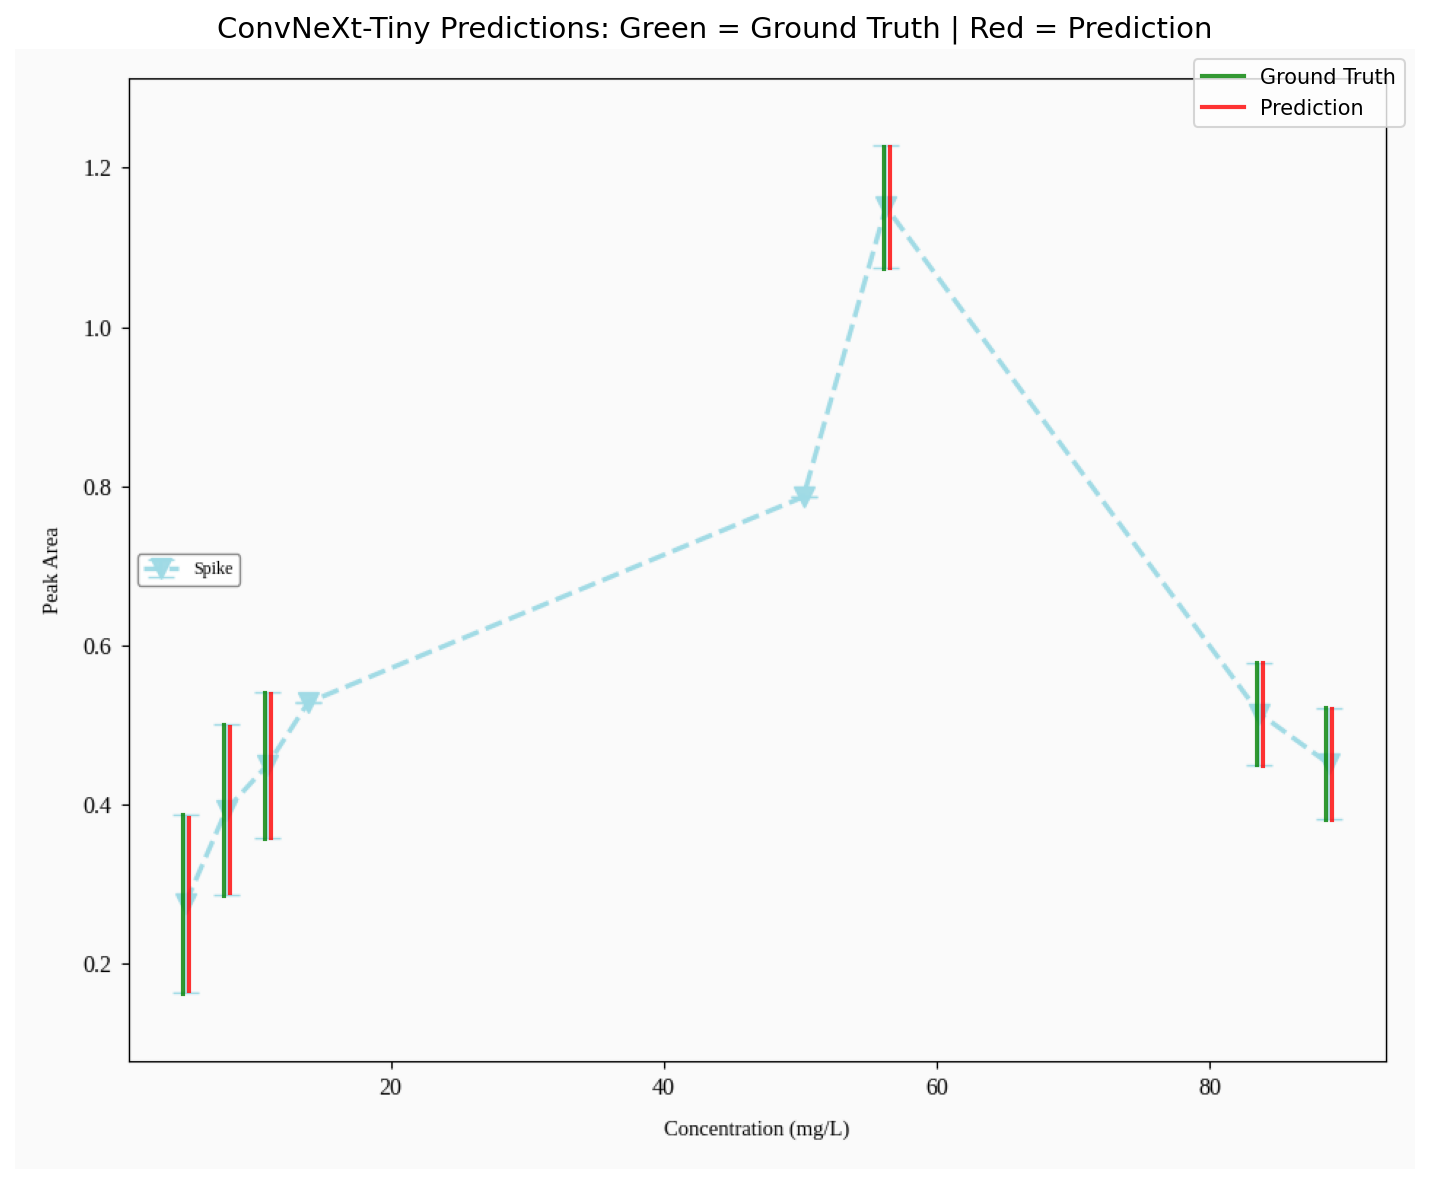

Sample 8: c97259dd-94fc-4235-ad3c-c83775493524


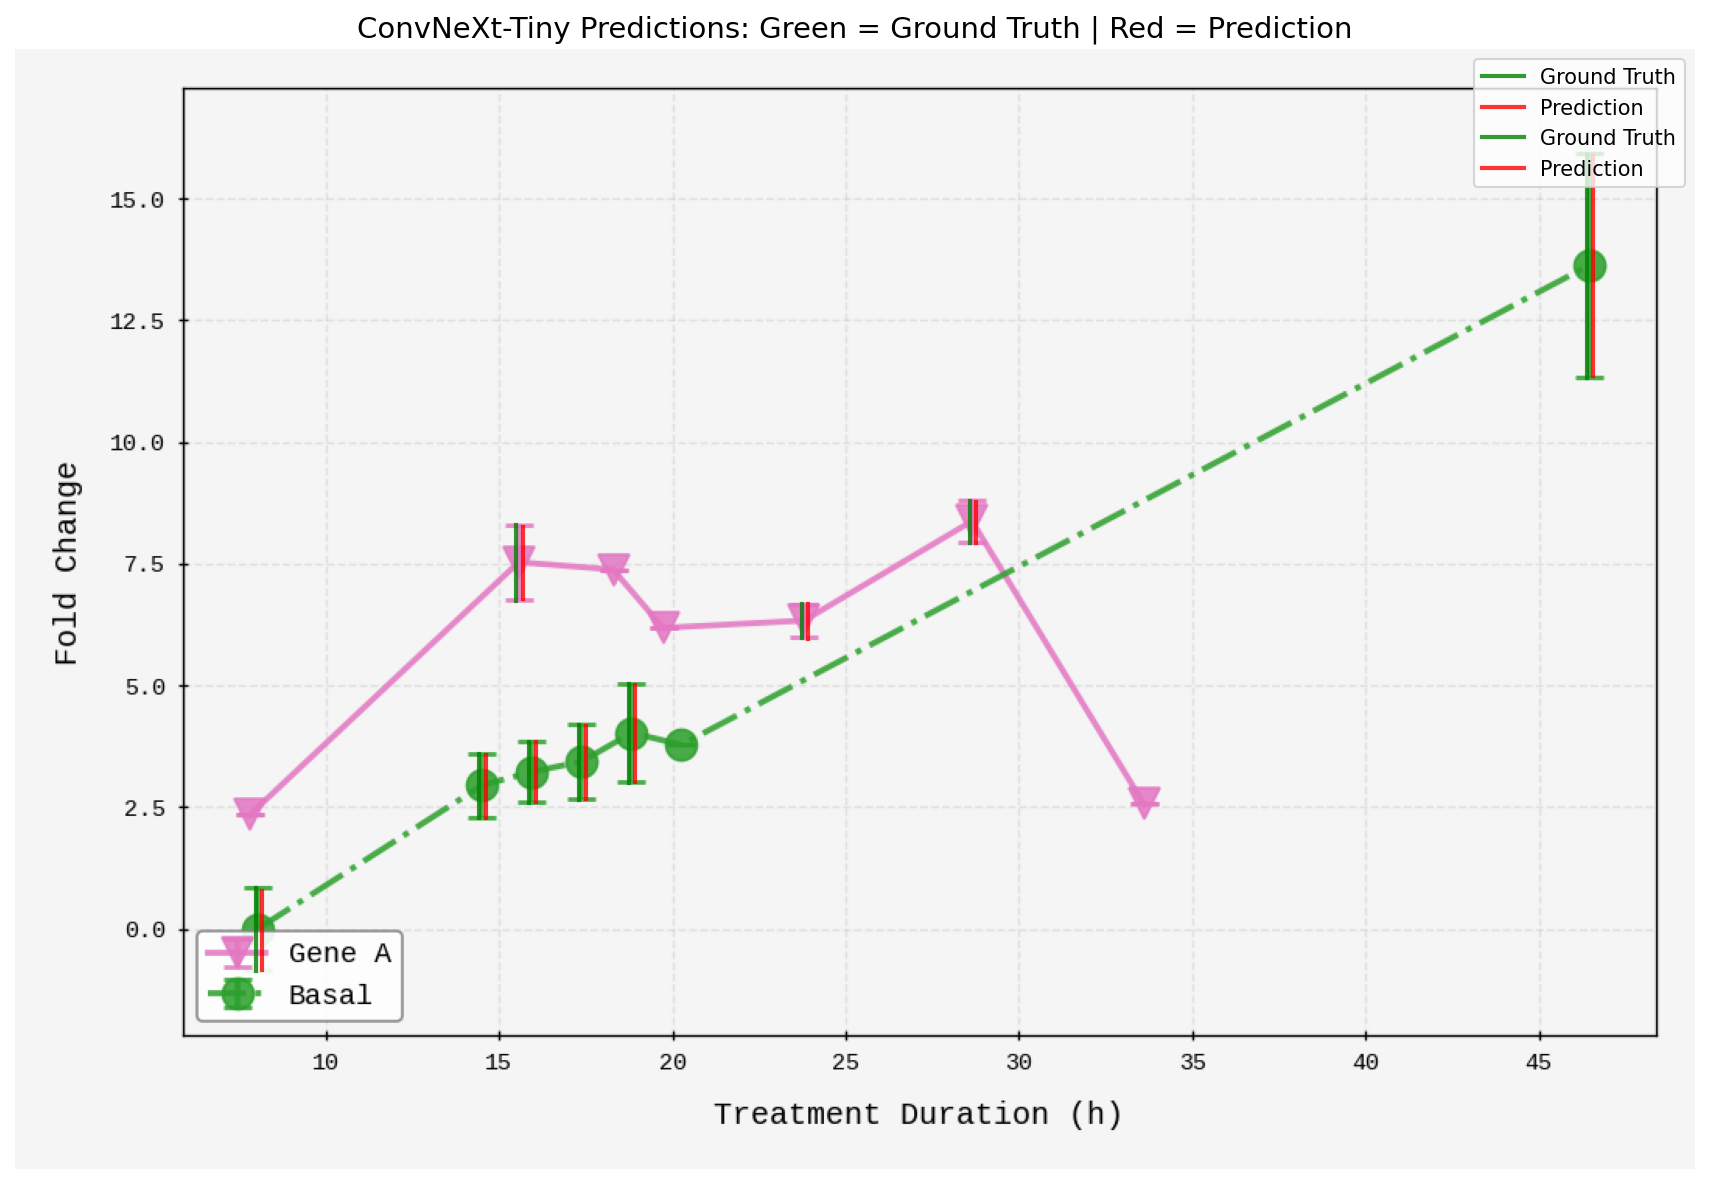

Sample 9: 01fa6173-7024-4945-8a9a-8bb181ad8cde


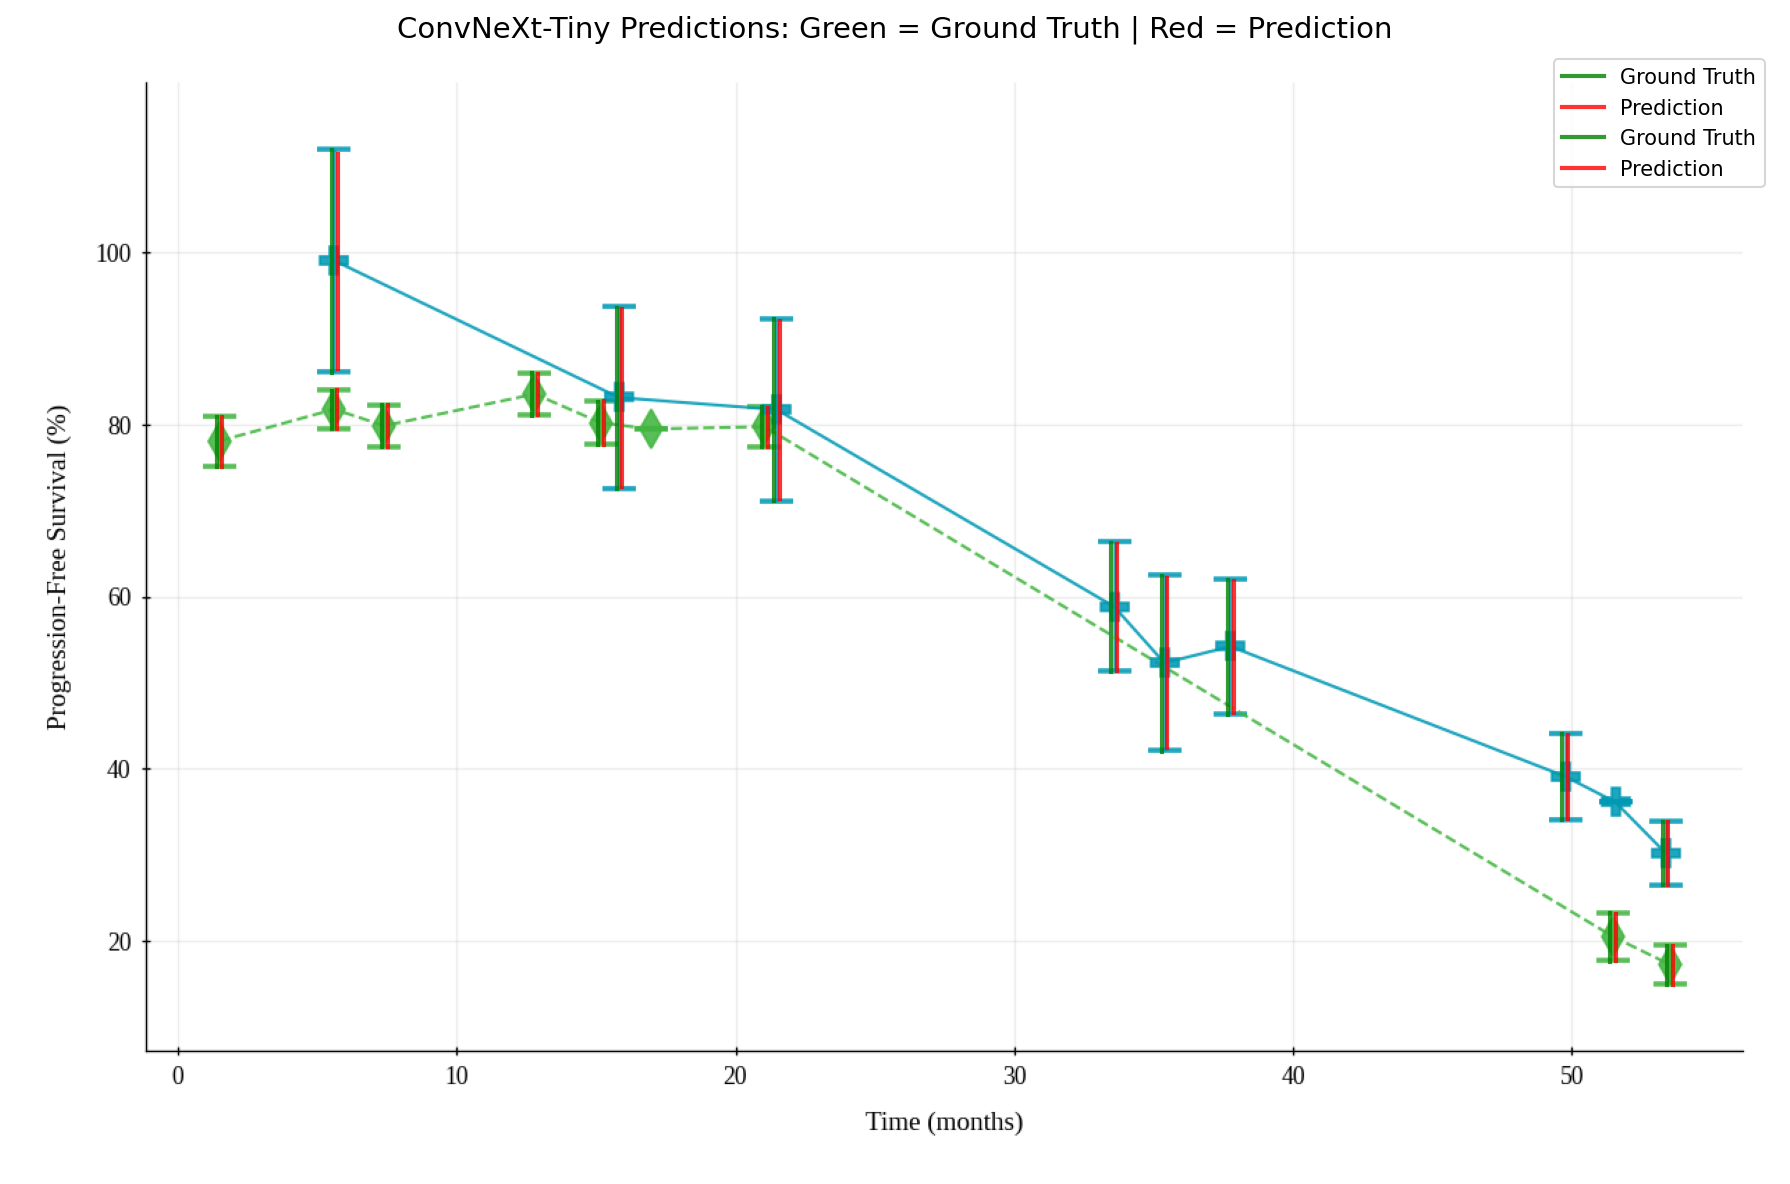

Sample 10: b6088e22-91ad-4152-9493-5b0f7fb2d1e8


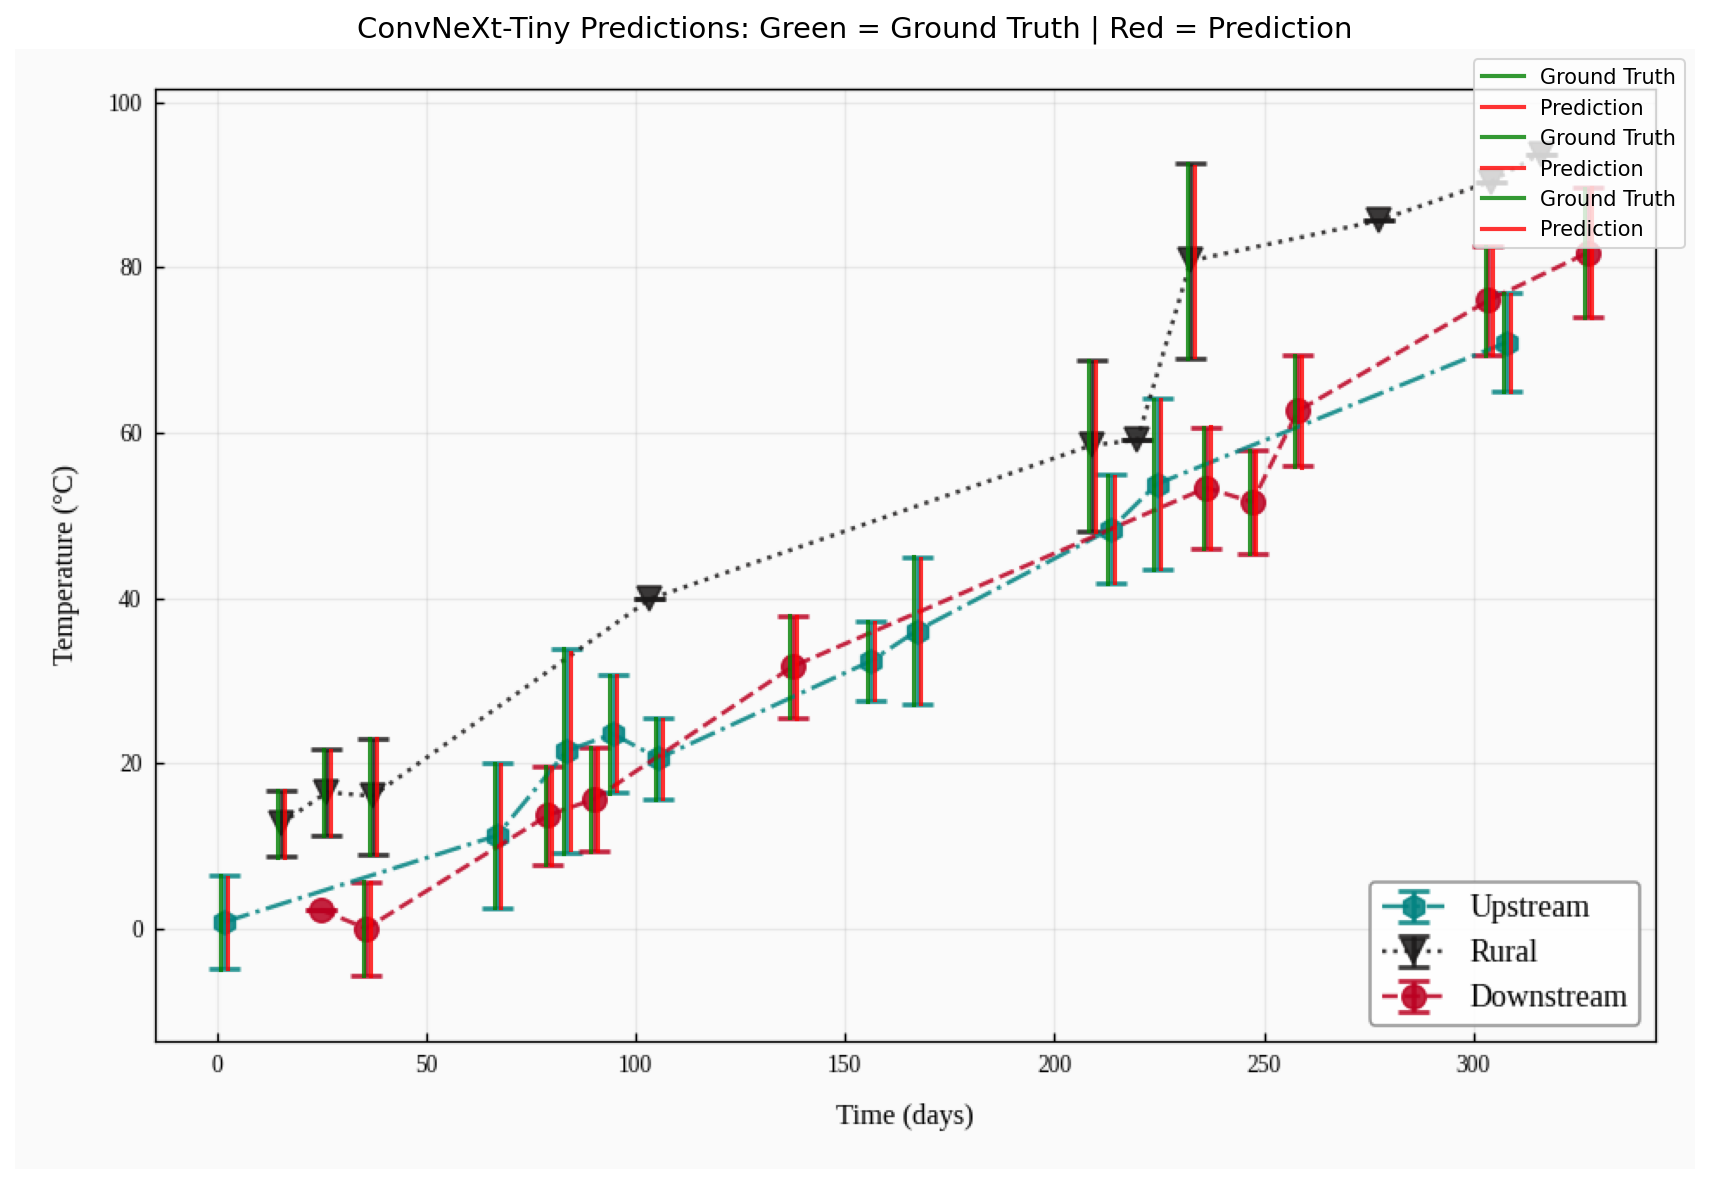

Sample 11: 6ef851a3-1658-4102-ae5b-38d0cf46f2c5


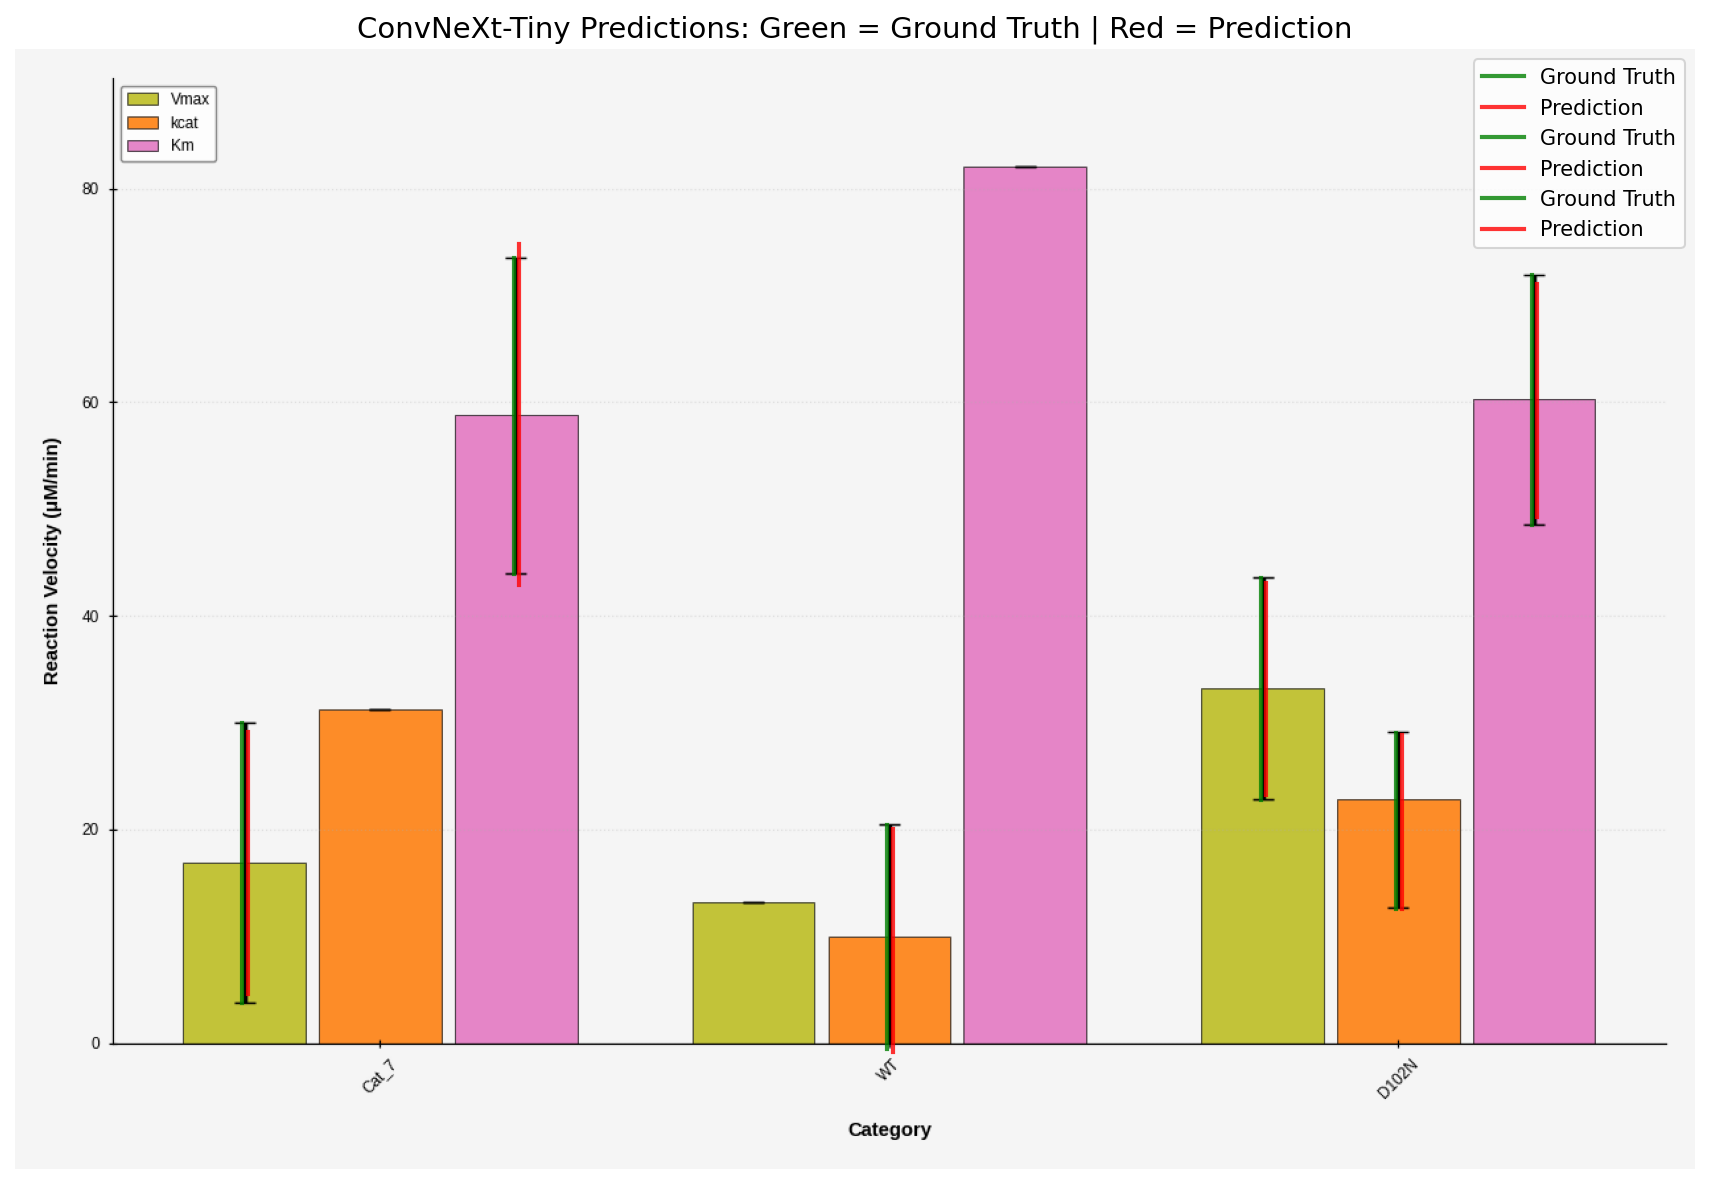

Sample 12: 5c5327a2-8c53-4505-959b-8c34ce9b54d3


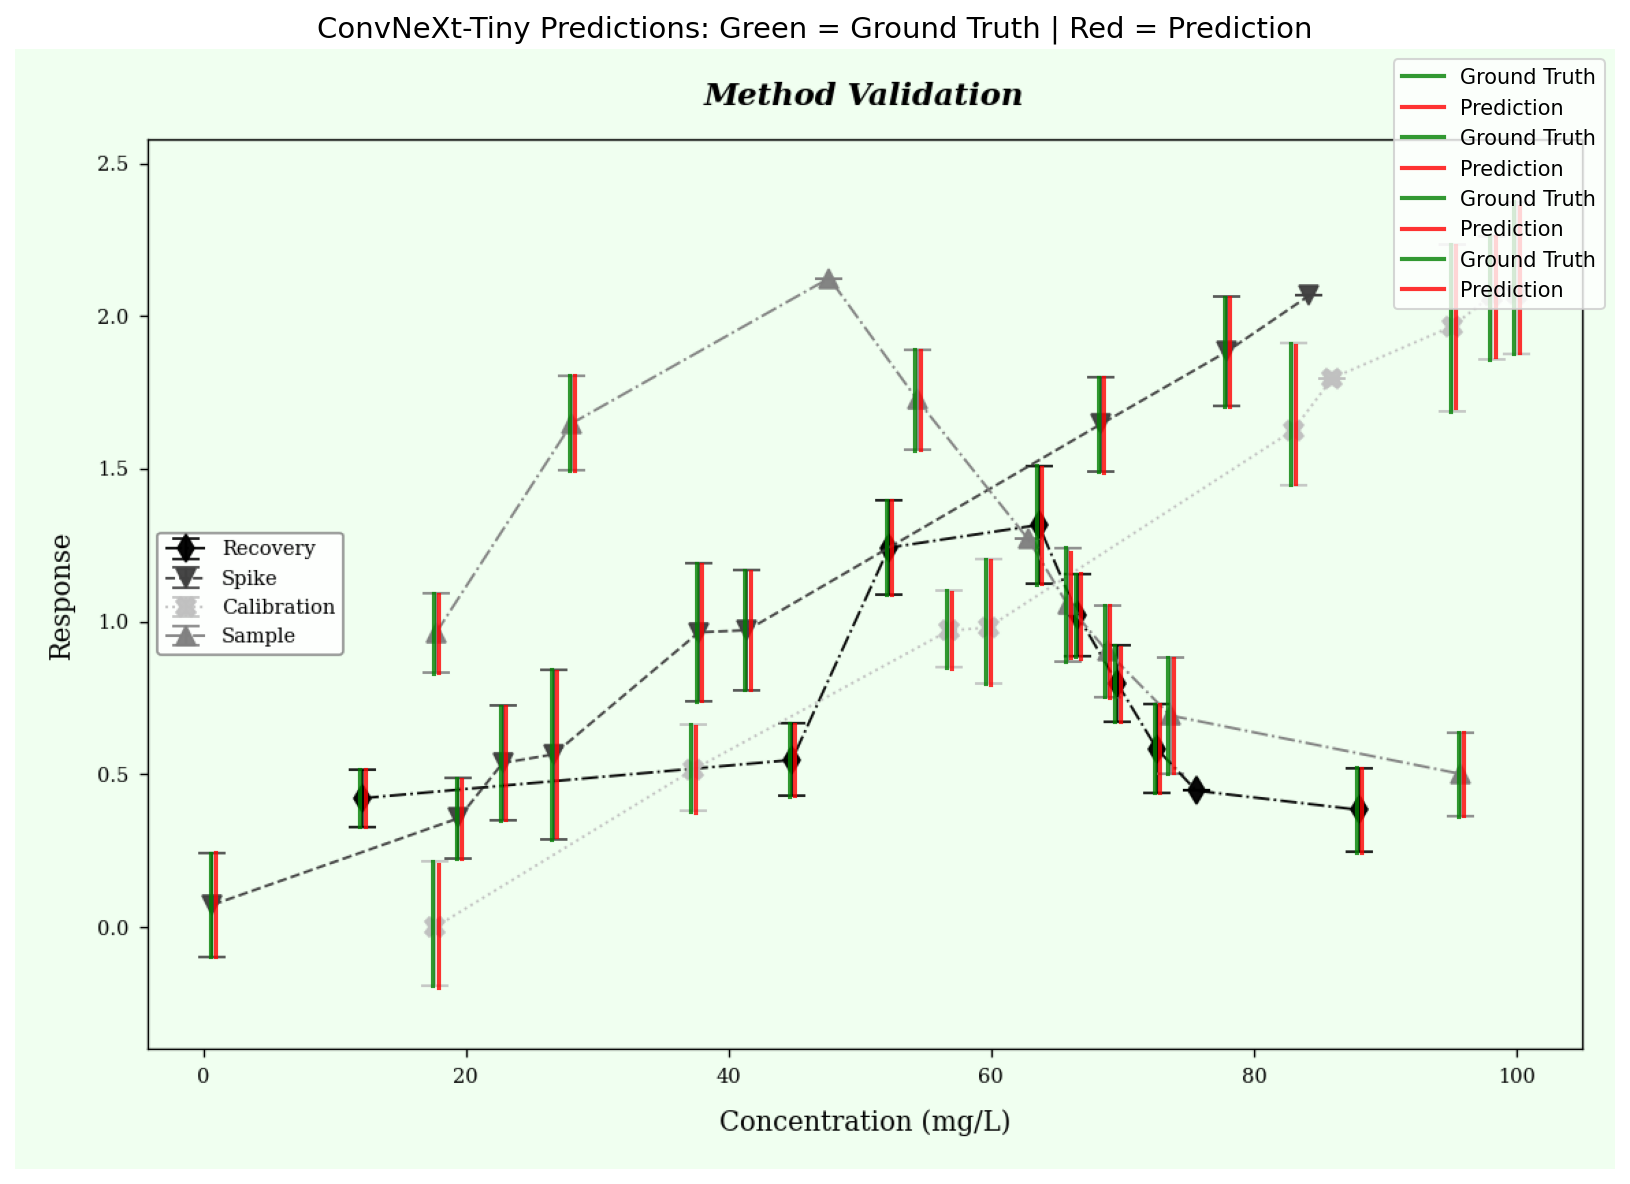

Sample 13: 1ae74e49-7ec6-4e81-92b0-b8579a512341


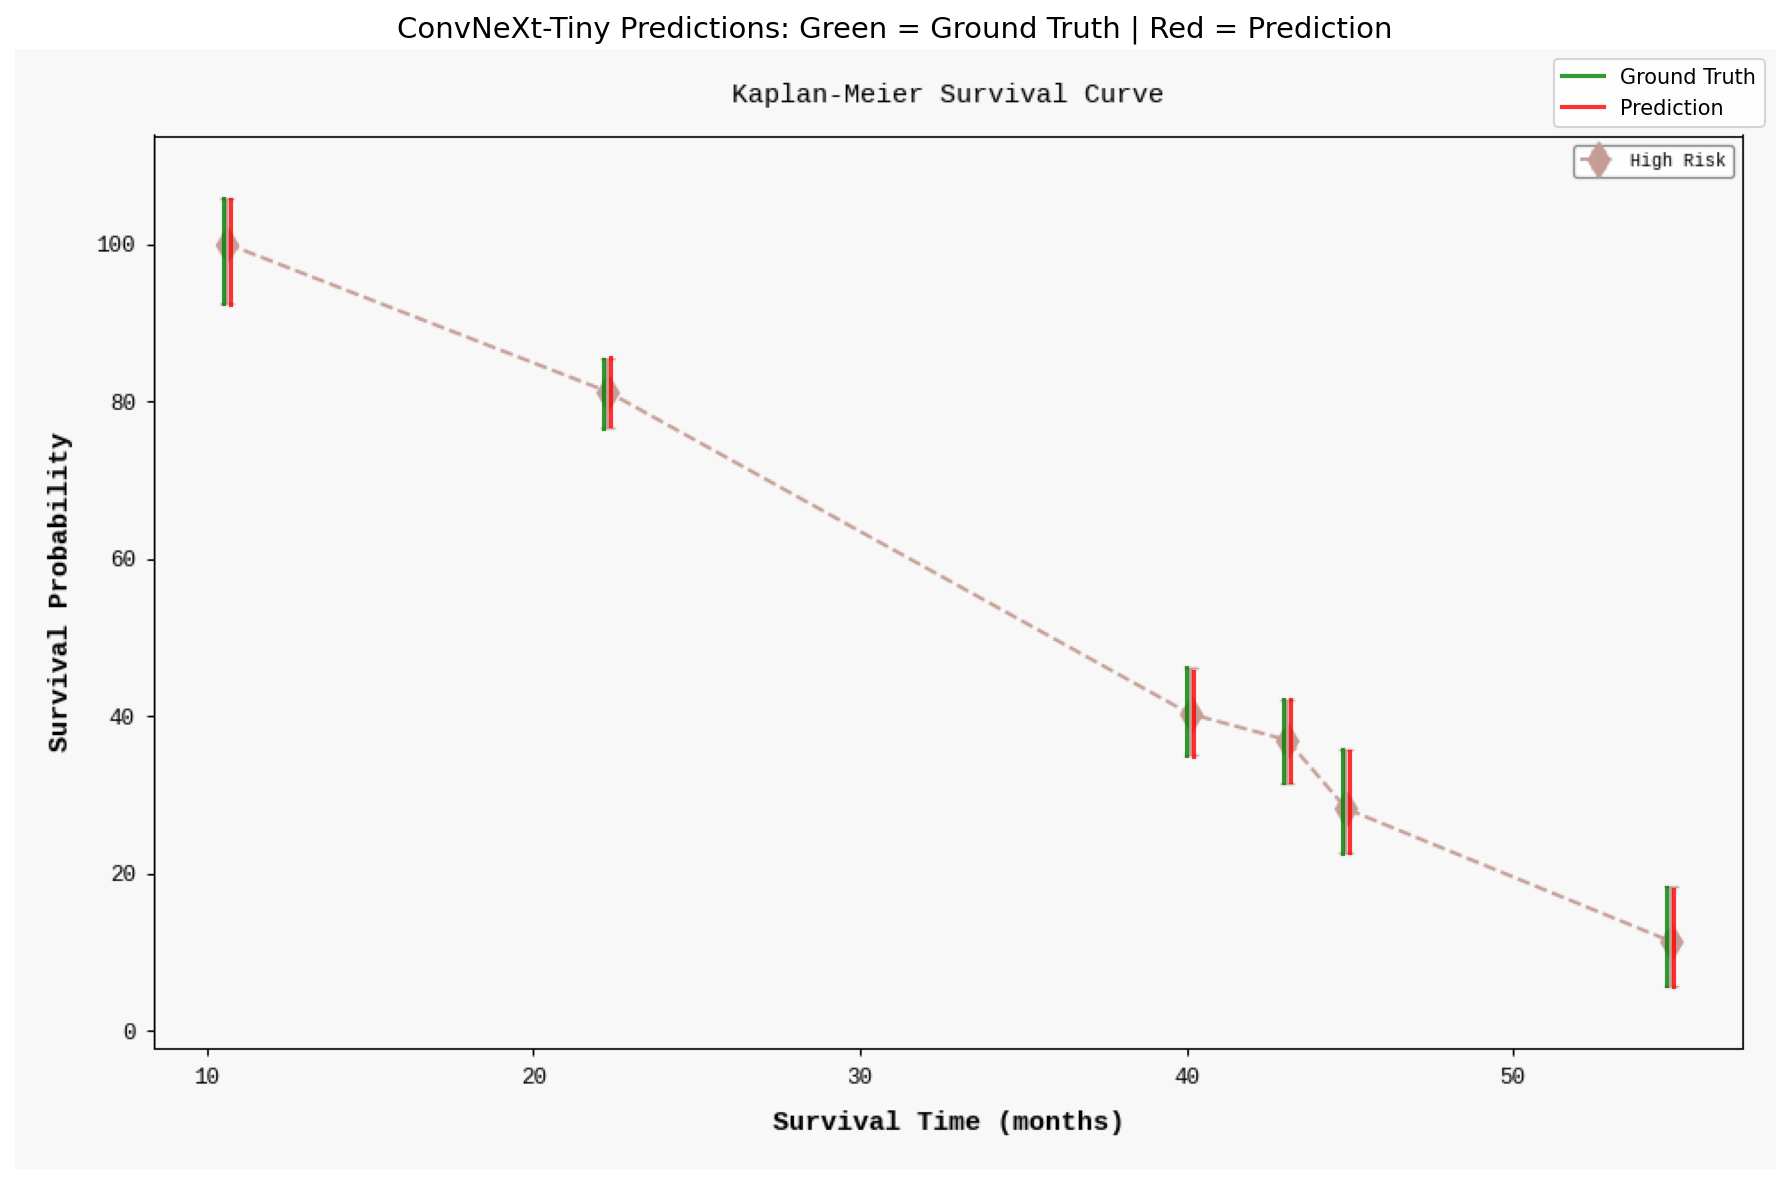

Sample 14: bcd6484e-f3c0-4689-99e1-de9d64d9d9b1


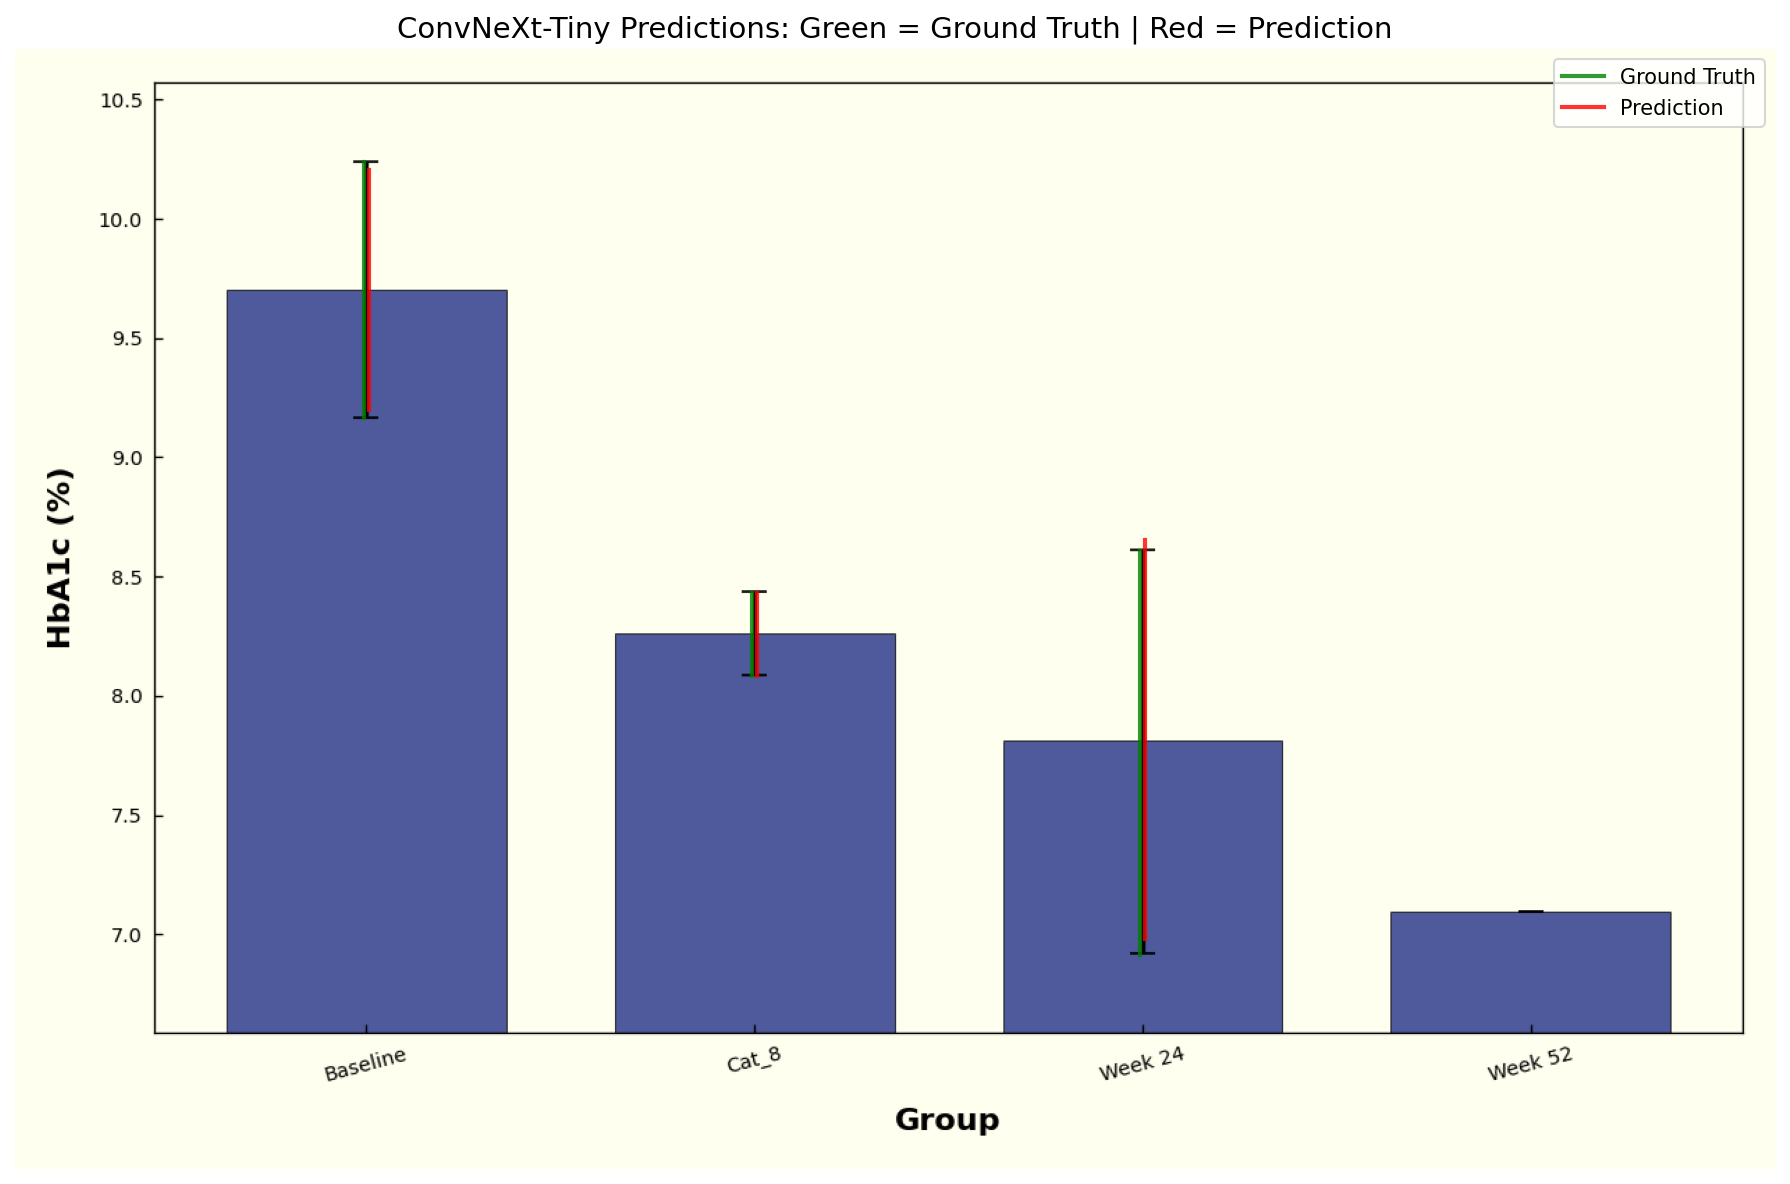

In [13]:
for i in range(14):
    file_id = test_files[i]
    
    visualize_sample(file_id, IMAGES_DIR, LABELS_DIR, model)
    print(f"Sample {i+1}: {file_id}")
    display(IPImage(filename="sample_visualization.png"))